# Exploring effects of order and parity of spherical harmonic representations in protein-ligand docking
Ada Fang, Tom Cobley

## Acknowledgements
We would like to thank Bowen Jing, Hannah Lawrence, Dr Mario Geiger and Prof. Tess Smidt for their insightful contributions and advice that helped to shape this project.

## Introduction and Problem Statement
Spherical harmonics are useful for constructing equivariant models that respect the rotational symmetry of data. Incorporation of SE(3) equivariance with spherical harmonics in DiffDock [1] has resulted in achieving state-of-the-art accuracy in blind protein-ligand docking.<sup>*</sup>
DiffDock is a SE(3)-equivariant generative model with a diffusion process over the non-Euclidean manifold of ligand conformations which learns the best ligand conformations for a given protein. Their diffusion model uses convolutional networks which are based on tensor products of irreducible representations of SO(3). In this work, we aim to conduct a study on the effect of different orders and parity of spherical harmonic representations on training behaviour and generalisation ability of the model. We aim to provide more insight into possible trade-offs relating to this important design choice, and a deeper understanding of the effects of this choice.

<sup>*</sup>Blind docking differs from traditional docking in that the location of the binding site is not known. Therefore, the docking algorithm is required to predict the best binding site as well as the best pose for the ligand in that site.

## Related Work
### Protein-ligand docking
EquiBind [2] and TANKBind [3] are other graph neural network-based models that aim to solve the blind protein-ligand docking problem. Both of these models are SE(3)-equivariant, but they do not use spherical harmonic representations. These models are both regression-based and are trained to minimise the error (distance) between ligand position predictions and ground truth. In contrast, DiffDock treats protein-ligand docking as a generative modelling problem by learning the distribution of ligand conformations for a protein. DiffDock significantly outperforms the other two methods (and all other baselines), setting the current state-of-the-art for blind protein-ligand docking. 

### Experiments with different spherical harmonic irreps
There is limited work using spherical harmonic irreps for the specific problem of protein-ligand docking (to the best of our knowledge, only DiffDock has explored this so far). However, this approach has been successfully applied to a range of other interesting problems, which we hope to take inspiration from. We are particularly interested in existing work which investigates the effect of the order of spherical harmonic irreps on model training characteristics, so we have selected the following publications from the field of molecular dynamics which have conducted such studies.

### Batzner et al., 2022
Batzner et al. [4] presented Neural Equivariant Interatomic Potentials (NequIP), an E(3)-equivariant message passing neural network for learning interatomic potentials for molecular dynamics using E(3)-equivariant convolutions, (implemented with `e3nn` [5]). NequIP demonstrates exceptional data efficiency (outperforming existing models while using up to three orders of magnitude fewer training data). To investigate remarkable data efficiency, the authors conducted a set of experiments in which they explicitly disabled interactions of a higher order than $l_{max} \in \{0,1,2,3\}$ and evaluated the rate at which their model was able to learn interatomic potentials for water and aspirin molecules
\footnote{$l_{max}$ represents the maximum angular momentum quantum number of the spherical harmonic irreps.}
. The learning curves of test error $\epsilon$ against number of training points $N$ were observed to follow the empirical deep learning power-law $\epsilon = a N^b$, where $a$ and $b$ are real constants [6]. These results are shown in (Fig. 5 in [4]). The \textit{learning exponent}, $b$, in this power-law relationship (or equivalently the slope of the line log-log space), represents how fast the model learns as more training data becomes available. For both water and aspirin molecules, the magnitude of learning exponent increased significantly from $l_{max}=0$, an invariant model, to $l_{max}=1$ an equivariant model, showing that equivariant models are able to learn faster as new data becomes available. This is a particularly interesting result as it breaks the empirical pattern shown in previous work that this learning exponent remains fixed for different learning methods [6].  Further increases in $l_{max}$ resulted in further, smaller improvements in predictive accuracy but no change in learning exponent.

#### Controlling for model capacity
A larger choice of $l$ directly increases the number of learnable parameters in the model, so it is important to account for this in experiments on training behaviour. Batzner et al. perform an additional weight-controlled experiment by training an invariant and an equivariant model with the same number of parameters (by increasing the multiplicities of the $l=0$ irreps in the invariant model to match the capacity of the equivariant model). The larger $l=0$ model performed comparably with the original, smaller $l=0$ model, verifying that the performance boost comes from the expressivity of equivariance rather than the increased model capacity. Hence, for interatomic potentials, this paper highlights the importance of equivariant models for accuracy and data efficiency.

### Owen et al., 2023
Owen et al. [8] performed a similar experiment to Batzner et al. [4], evaluating the learning exponent of the same model on the force fields of transition metals. They experimented with even higher $l_{max} \in \{0,1,2,3,4,5\}$. For Au, Cu, Os, and Ti, they observed (as before) that higher $l$ yields greater magnitude learning exponents and lower predictive error. Interestingly, they observed significant continued improvements in predictive error and learning exponents for increased $l_{max}$ up to $l_{max} = 3$ before returns diminished. This is in contrast to the previous work which showed that water and aspirin molecules experience diminishing returns after $l_{max} = 1$. 

Intuitively, transition metals could require higher-order spherical harmonics due to the higher symmetry of their $d$-orbitals, which is in contrast to the lower symmetry orbitals of water and aspirin. It would be interesting to extrapolate these observations to the problem of protein-ligand docking, which is also a relatively low symmetry system. We suspect that learning rate and model improvement will benefit from an equivariant model, and will saturate at a lower $l$ similar to the water, apsirin examples.


## Background
DiffDock is denoising diffusion model over the space of ligand conformations with respect to a fixed protein target. A ligand conformation $x$ lies in space $\mathbb{R}^{3n}$ which is a $\mathbb{R}^{3}$ vector for each of the $n$ atoms. Ligand conformations cannot diffuse over all of $\mathbb{R}^{3n}$, and thus DiffDock considers the manifold of more feasible ligand conformations given by the product of three vector spaces, $\mathbb{P} = \mathbb{T}_3 \times SO(3) \times SO(2)^m$:

* Position of the ligand with respect to the protein: $\mathbb{T}_3 \cong \mathbb{R}^3$. The model is $SE(3)$-equivariant to translations, $\mathrm{A_{tr}}: \mathbb{T}_3 \times \mathbb{R}^3 \rightarrow \mathbb{R}^3$ where $\mathrm{A_{tr}} (r,x)_i = x_i + r$, for each atom $i\in [1,n]$.
* Rotation of the ligand with respect to the protein: $SO(3)$. The model is $SE(3)$-equivariant to rotations, $\mathrm{A_{rot}}: SO(3) \times \mathbb{R}^3 \rightarrow \mathbb{R}^3$ where $\mathrm{A_{rot}} (R,x)_i = R(x_i-\bar{x}) + \bar{x}$, for each atom $i\in [0,n]$ and $\bar{x}=\frac{1}{n}\sum_{i}x_i$ is the unweighted center of mass of the ligand.
* Torsion angles within the ligand: $SO(2)^m$ where there are $m$ torsion angles in the molecule. The model is $SE(3)$-invariant to torsion angle updates, $\mathrm{A_{tor}}: SO(2)^m \times \mathbb{R}^3 \rightarrow \mathbb{R}^3$ where $\mathrm{A_{tor}} (\theta,x)_i = \mathrm{RMSDAlign}(x, (B_{1,\theta_1}\circ \cdots \circ B_{m,\theta_m})(x))$. $B_{k,\theta_k}$ is the torsion update of angle $\theta_k$ around bond $k$ and RMSDAlign finds the rigid body displacement of the ligand with torsion angle updates that is closest in RMSD to the original ligand position at $x$.

We will draw on concepts of equivariance and invariance from class to understand these models to test how the model maintains equivariance and invariance with these transformations. 

In denoising diffusion models the forward process is the application of noise over time $t$ until the ligand is just random noise, and the model aims to learn the reverse process to reconstruct the ligand given the noisy ligand pose and $t$. During training the model first samples a time $t$ and the corresponding noise that would be applied on each component of the product space $(r_t, R_t, \boldsymbol{\theta}_t)$. The noise is applied to the ligand $x_t = A((r_t, R_t, \boldsymbol{\theta}_t), x_0)$, where $x_0$ is the starting ligand pose. Then the score model $s(x_t, y, t) = \alpha \in \mathbb{R}^3, \beta \in \mathbb{R}^3, \gamma \in \mathbb{R}^3$ is given the noisy ligand pose $x_t$, the protein $y$, and time $t$ to predict the score of the distribution on each component $\nabla \log p_t^{tr}(r_t|r_0), \nabla \log p_t^{rot}(R_t|R_0), \nabla \log p_t^{tor}(\boldsymbol{\theta}_t|\boldsymbol{\theta}_0)$ respectively.

The score model is a neural network comprised of the following layers:
* Embedding layer: A radial graph with distance based cutoffs is constructed for the ligand atoms and the C$\alpha$ atoms of each amino acids residue in the protein. The ligand atoms have molecular features such as: atomic element, chirality, formal charge etc. The amino acids use features from ESM [9] embeddings, a protein sequence language model. Finally the edge features are the distances between nodes. A learnable two-layer MLP is then used to embed the scalar features of each node and edge. A diagram of the construction of the graph in the embedding layer is shown below.
* Interaction layers: Messages passing is done between the nodes of the graph in this layer. The messages are given by weighted tensor products spherical harmonic representations of the edge vectors and the node features. For every node of type $t_a$ and a neighbouring node of type $t$, where $\mathcal{N}_a^{(t)}$ are all the neighbouring nodes of type $t$, the update to $h_a$ is given by:
    $$\begin{gathered}\mathbf{h}_a \leftarrow \mathbf{h}_a \underset{t \in\{\ell, r\}}{\oplus} \mathrm{BN}^{\left(t_a, t\right)}\left(\frac{1}{\left|\mathcal{N}_a^{(t)}\right|} \sum_{b \in \mathcal{N}_a^{(t)}} Y\left(\hat{r}_{a b}\right) \otimes_{\psi_{a b}} \mathbf{h}_b\right) \text { with } \psi_{a b}=\Psi^{\left(t_a, t\right)}\left(e_{a b}, \mathbf{h}_a^0, \mathbf{h}_b^0\right)\end{gathered}$$
    The model uses spherical harmonics up to $l=2$ and limits the output spherical harmonics to $l=1$. All learnable weights are given by $\Psi$.
* Output layer: For $\alpha, \beta$, which are $SE(3)$-equivariant scores for translation and rotation of the ligand respectively, this is given by a convolution of the ligand atoms and the unweighted center of mass of the ligand, $c$.
    $$
    \begin{gathered}
    \mathbf{v} \leftarrow \frac{1}{\left|\mathcal{V}_{\ell}\right|} \sum_{a \in \mathcal{V}_{\ell}} Y\left(\hat{r}_{c a}\right) \otimes_{\psi_{c a}} \mathbf{h}_a 
    \quad \text { with } \psi_{c a}=\Psi\left(\mu\left(r_{c a}\right), \mathbf{h}_a^0\right)
    \end{gathered}
    $$
    The scores are then given by the sum of the 1o and 1e representations, which the authors claim this is because of the use of coarse-grained representations of the protein at the residue level. 

    The $\gamma$ score for the $m$ torsion angles of the ligand is given by updating the edge features of rotatable bonds $g$ with convolutions with all ligand nodes:
    $$
    \begin{gathered}
    \mathcal{E}_\tau=\left\{(g, b) \mid g \text { a rotatable bond, } b \text{ a ligand node}\right\} \\
    \mathbf{h}_g=\frac{1}{\left|\mathcal{N}_g\right|} \sum_{b \in \mathcal{N}_g} T_g\left(\hat{r}_{g b}\right) \otimes_{\gamma_{g b}} \mathbf{h}_b \\
    \text { with } \gamma_{g b}=\Gamma\left(e_{g b}, \mathbf{h}_b^0, \mathbf{h}_{g_0}^0+\mathbf{h}_{g_1}^0\right), \; e_{g b}=\Upsilon^{(\tau)}\left(\mu\left(r_{g b}\right)\right)  \forall(g, b) \in \mathcal{E}_\tau, \;
    T_g(\hat{r}):=Y^2\left(\hat{r}_g\right) \otimes Y(\hat{r})
    \\
    \end{gathered}
    $$
    The learnable parameters are in the MLPs, $\Upsilon^{(\tau)}$ and $\Gamma$. The spherical harmonics $Y(\hat{r})$ are given up to $l=2$ and the output of $T_g(\hat{r})$ is filtered up to $l=3$. Finally a two layer MLP is used $ \delta \tau_g=\Pi\left(\mathbf{h}_g^{\prime}+\mathbf{h}_g^{\prime \prime}\right)$ where $\mathbf{h}_g^{\prime}$ and $\mathbf{h}_g^{\prime \prime}$ are the 0e and 0o irreps.

We will draw on concepts from the course to better understand how these irreducible representations result in SE(3)-equivariant and SE(3)-invariant scores, and how varying the order and multiplicity of spherical harmonic representations will affect model performance. The goal is to provide justification for the author's choice of order and parity. Our investigation will also involve techniques beyond the scope of the course, such as an understanding of denoising diffusion models on Riemannian manifolds.

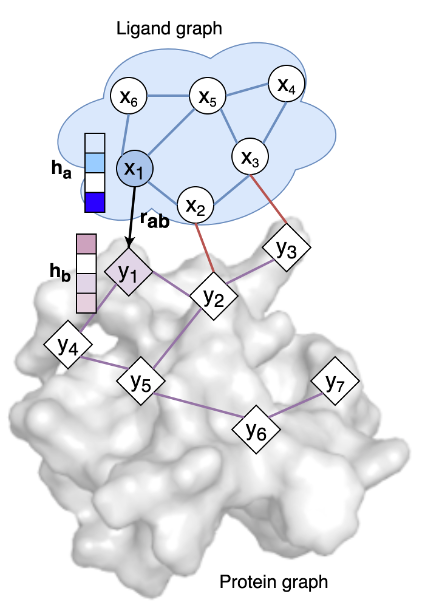

In [1]:
from IPython.display import Image
display(Image(filename='figures/embedding_layer.png'))

The above diagram was created with draw.io

## Methods
All code can be found at https://github.com/tomcobley/DiffDockExperiments which is forked from DiffDock.

We will extend on the open-source DiffDock codebase (https://github.com/gcorso/DiffDock) by implementing experimentation scripts for testing different $l_{max}$ and multiplicity under controlled experimental conditions. DiffDock uses the `e3nn` library to implement spherical harmonics, which we will experiment with. 

It is prohibitively expensive for us to perform multiple, full training runs of DiffDock due to the large compute requirements (one training run (850 epochs) takes approx. 18 days on four 48GB RTX A6000 GPUs). Instead, following the approach often taken in the literature when performing hyperparameter tuning / ablation studies, we will train multiple smaller versions of the model on a subset of the training data. Insights from these experiments may be extrapolated to full-size models.

Our planned approach is to scale down the model by reducing the number of learnable parameters (e.g. by reducing the multiplicities of each irrep in a consistent manner). The full model is trained on PDBbind, a large dataset of protein-ligand crystal structures. To avoid underfitting, we will also scale down the training dataset size accordingly. This should result in faster convergence, allowing us to make meaningful comparisons over the shorter training runs. 


### Setting up the code base
* Set up a python 3.7 virtual environment.
* Install dependencies with `pip install -r requirements.txt`
* Clone the esm library as well https://github.com/facebookresearch/esm it is needed to generate protein embeddings for training

### Data preparation
Here we only considered proteins with `UniProtID = P00918` (the most common UniProtID in PDBBind) which leaves us with 425 complexes of the P00918 protein with different ligands which was split into 80:10:10 train:test:validation.

Download processed PDBBind data from https://zenodo.org/record/6408497

Unzip the directory and place it into data such that you have the path `data/PDBBind_processed`

In [ ]:
# Data preparation
!python datasets/pdbbind_lm_embedding_preparation.py --splits_dir data/P00918_split 

# In the esm repo, extract the embeddings for the pdbbind sequences
!python scripts/extract.py esm2_t33_650M_UR50D pdbbind_sequences.fasta embeddings_output --repr_layers 33 --include per_tok --truncation_seq_length 4096

# Convert the embeddings to .pt files for pytorch
!python datasets/esm_embeddings_to_pt.py --output_path data/P00918_esm2_3billion.pt

### Training DiffDock
We added the following hyperparameters in the code base to vary $l_{max}$ and the out irreps in the final convolutional layer which is `1o+1e` for the translation and rotation score, and `0o+0e` for the torsional score. 
We will use these to test the effects of these choices on the performance of DiffDock.
* `--use_order_repr` specifies $l_{max} \in \{0,1,2,3\}$, the irreducible representations of each $l_{max}$ is specified below in Experiments
* `--use_sh_lmax` specificies $l_{max} \in \{0,1,2,3\}$ of the spherical harmonics that are used to tensor product with the node features
* `--no_even_irreps` if this is added as a flag then the `1e` irrep, which is a pseudovector, is ignored in the final convolutional layer. So the final convolutional layer for the score of the translation and rotation component is given by the `1o` irrep only.
* `--no_odd_irreps` if this is added as a flag then the `1o` irrep, which is a conventional vector, is ignored in the final convolutional layer. So the final convolutional layer for the score of the translation and rotation component is given by the `1e` irrep only.
* `--no_even_tor_irreps` if this is added as a flag then the `0e` irrep, which is a conventional scalar, is ignored in the final convolutional layer. So the final convolutional layer for the score of the torsional component is given by the `0o` irrep only.
* `--no_odd_tor_irreps` if this is added as a flag then the `0o` irrep, which is a pseudoscalar, is ignored in the final convolutional layer. So the final convolutional layer for the score of the torsional component is given by the `0e` irrep only.
* `--use_1o_translations_1e_rotations` if this is added as a flag then the final convolutional layer for the translation is given by the `1o` irrep and the rotation score is given by the `1e` irreps only. This is different to `no_even_irreps` and `no_odd_irreps` as they set the irreps for the translation and rotation score together.

Example script:

This script cannot be run in the Jupyter Notebook due to GPU requirements.

In [ ]:
!python -m train --run_name SPECIFY_RUN_NAME --test_sigma_intervals --esm_embeddings_path data/P00918_esm2_embeddings.pt --log_dir workdir\
    --lr 1e-3 --tr_sigma_min 0.1 --tr_sigma_max 19 --rot_sigma_min 0.03 --rot_sigma_max 1.55 --batch_size 4 \
    --num_conv_layers 6 --dynamic_max_cross --scheduler plateau --scale_by_sigma --dropout 0.1 --remove_hs --c_alpha_max_neighbors 24\
    --receptor_radius 15 --num_dataloader_workers 1 --cudnn_benchmark --val_inference_freq 5 --num_inference_complexes 500 --use_ema\
    --distance_embed_dim 64 --cross_distance_embed_dim 64 --sigma_embed_dim 64 --scheduler_patience 30 --n_epochs 1000\
    --split_train data/P00918_split/P00918_train --split_val data/P00918_split/P00918_val --split_test data/P00918_split/P00918_test\
    --cache_path data/P00918_cache --wandb --data_dir data/PDBBind_processed\
    <SEE ADDITIONAL FLAGS TO ADD IN EXPERIMENTAL SECTION>

We used double precision Tesla V100s cards with 32GB of VRAM and trained each run for at least 48 hours.

### Evaluating DiffDock on Test Set
Run inference on the test set with the following script. Note that there is also a confidence model to rank the generated structures from the diffusion model. We do not retrain this model and use the published model provided by DiffDock. The `rmsds_below_2` and `rmsds_below_5` metrics are the proportion of generated structures that are within 2 and 5 Angstroms of the ground truth structure respectively. The `filtered_rmsds_below_2` and `filtered_rmsds_below_5` metrics are the proportion of generated structures that are within 2 and 5 Angstroms of the ground truth structure after only considering the highest ranked confidence model structures. For the purposes of our analysis since we did not train the confidence model we only consider the `rmsds_below_2` and `rmsds_below_5` metrics.

In [ ]:
!python -m evaluate --model_dir workdir/<MODEL_NAME> --run_name RUN_NAME --ckpt best_ema_inference_epoch_model.pt --out_dir OUTPUT_DIRECTORY --confidence_ckpt best_model_epoch75.pt \
    --confidence_model_dir workdir/paper_confidence_model --inference_steps 20 --split_path data/P00918_split/P00918_test --samples_per_complex 40 --batch_size 10 --actual_steps 18 --no_final_step_noise \
    --cache_path data/P00918_cache --data_dir data/PDBBind_processed 

## Experiments
The code for the implementation can be found in `models/score_model.py`

### Effect of order of irreps, $l_{max}$ and $sh l_{max}$ values
For the interaction layers, we are interested in seeing the effects of different order irreps and their multiplicities. In the paper, DiffDock filters down to only the $l=l_{max} \in \{0, 1\}$ irreps and uses $shl_{max}$ of 2 for the interaction layers. We would like to provide more insight into these choices of $l_{max}$ and see if other alternatives exist. 

First, we will train four (smaller) versions of the model, with $l_{max} \in \{0, 1, 2, 3\}$ and $shl_{max} \in \{2, 2, 3, 4\}$. Following the approach of [4], we will also train weight- and feature-controlled versions of the model by fixing the multiplicities of the irreps to ensure that all four models have the same number of parameters and features, so are directly comparable after training on the same training data subset using a fixed compute budget.

#### Implementation
These experiments can be achieved by manipulating the `in_irreps` and `out_irreps` used in the `e3nn` tensor products. Below are some different order irrep sequences for each interaction layer that we will test. The `irrep_order` refers to `l_max` of the spherical harmonics we will tensor product for each layer. Each `irrep_seq` is used to instantiate the convolutional interaction layers with inputs/outputs corresponding to each consecutive pair of elements in the `irrep_seq` list. We will vary `ns` and `nv` for each experimental / model setup as described above for weight controlling.

The $l_{max}$ can be set with the `--use_order_repr` flag which takes an integer specifying $l_{max}$.

In [109]:
# Example values:
ns = 8              # Number of hidden features per node of order 0 (scalar)
nv = 2              # Number of hidden features per node of order > 0 (vector)
irrep_order = 2     # l_max

if irrep_order == 0:
    irrep_seq = [
        f'{ns}x0e',
        f'{ns}x0e',
        f'{ns}x0e',
        f'{ns}x0e',
    ]
elif irrep_order == 1:
    irrep_seq = [
        f'{ns}x0e',
        f'{ns}x0e + {nv}x1o',
        f'{ns}x0e + {nv}x1o + {nv}x1e',
        f'{ns}x0e + {nv}x1o + {nv}x1e + {ns}x0o'
    ]
elif irrep_order == 2:
    irrep_seq = [
        f'{ns}x0e',
        f'{ns}x0e + {nv}x1o + {nv}x2e',
        f'{ns}x0e + {nv}x1o + {nv}x2e + {nv}x1e + {nv}x2o',
        f'{ns}x0e + {nv}x1o + {nv}x2e + {nv}x1e + {nv}x2o + {ns}x0o'
    ]
elif irrep_order == 3:
    irrep_seq = [
        f'{ns}x0e',
        f'{ns}x0e + {nv}x1o + {nv}x2e + {nv}x3o',
        f'{ns}x0e + {nv}x1o + {nv}x2e + {nv}x1e + {nv}x2o + {nv}x3o + {nv}x3e',
        f'{ns}x0e + {nv}x1o + {nv}x2e + {nv}x1e + {nv}x2o + {nv}x3o + {nv}x3e + {ns}x0o'
    ]

The above irrep sequences were calculated using the e3nn.o3 tensor product functions, an example is shown below.

In [3]:
from e3nn import o3

FullyConnectedTensorProduct(8x0e+2x1o+2x2e+2x1e+2x2o x 1x0e+1x1o+1x2e+1x3o -> 8x0e+2x1o+2x2e+2x1e+2x2o+8x0o | 264 paths | 264 weights)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

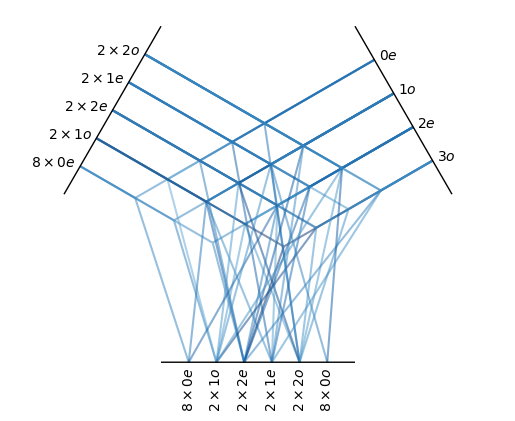

In [113]:
tp = o3.FullyConnectedTensorProduct(
    irreps_in1=irrep_seq[2],
    irreps_in2=o3.Irreps.spherical_harmonics(lmax=3),
    irreps_out=irrep_seq[3]
)
print(tp)
tp.visualize()

Variation of $shl_{max}$ can be set with the `--use_sh_lmax` flag which takes an integer specifying $l_{max}$ of the spherical harmonics used to tensor product with the feature vectors. These are given by the `e3nn.o3.Irreps.spherical_harmonics(lmax=use_sh_lmax)` function.

In [4]:
for i in range(4):
    print("use_sh_lmax = 1:", o3.Irreps.spherical_harmonics(lmax=i))

use_sh_lmax = 1: 1x0e
use_sh_lmax = 1: 1x0e+1x1o
use_sh_lmax = 1: 1x0e+1x1o+1x2e
use_sh_lmax = 1: 1x0e+1x1o+1x2e+1x3o


### Effect of output parity for translation, rotation, and torsion scores
The diffusion scores for the translation component is effectively the calculation of the acceleration of the center of the ligand and the rotation componenet is effectively the angular acceleration of the center of the ligand. The authors use the `1o+1e` irrep to calculate both scores, but we are interested in using other irreps. The `1o` irrep is a conventional vector, and the `1e` irrep is a pseudovector. We will test the effects of using only one of these irreps for the translation score, and the same for the rotation score. 

For the torsional score it is a pseudotorque scalar given for each rotatable bond, the authors use the `0o+0e` irrep, which is a scalar and a pseudoscalar. We will test the effects of using only one of these irreps for the torsional score. 

The goal of these experiments is to provide more insight into the parity of the output.

This is implemented in the code base with the following flags:
* `--no_odd_irreps`: removes the 1o component for the translation and rotation scores
* `--no_even_irreps`: removes the 1e component for the translation and rotation scores
* `--no_odd_tor_irreps`: removes the 0o component for the torsion score
* `--no_even_tor_irreps`: removes the 0e component for the torsion score
* `--use_1o_translations_1e_rotations`: uses the 1o component for the translation score and the 1e component for the rotation score. This is because the translation score should transform as a `1o` irrep, since it inverts under inversion, and the rotation score should transform as a `1e` irrep, since it does not invert under inversion.

### Effect of using SO(3) vs O(3)
The authors use the O(3) group which includes inversion symmetry. However, the combination of both the odd and even parities for the output diffusion scores motivates that the authors could also use the SO(3) group. We will test the effects of using the SO(3) group on model performance by removing all odd irreps by only using even irreps in the convolutional layers. The new irrep sequences are calculated with the `e3nn.o3` package and this gives us the following irreps which are implemented in `models/score_model.py`:

In [4]:
use_so3 = True
sh_lmax = 2
use_order_repr = 1
ns, nv = 8, 2

if use_so3: # set sh_lmax
    if sh_lmax == 0:
        sh_irreps = o3.Irreps('0e')
    elif sh_lmax == 1:
        sh_irreps = o3.Irreps('0e + 1e')
    elif sh_lmax == 2:
        sh_irreps = o3.Irreps('0e + 1e + 2e')
    elif sh_lmax == 3:
        sh_irreps = o3.Irreps('0e + 1e + 2e + 3e')

if use_so3: # set irrep sequence
    if use_order_repr == 0:
        irrep_seq = [
            f'{ns}x0e',
            f'{ns}x0e',
            f'{ns}x0e',
            f'{ns}x0e',
        ]
    elif use_order_repr == 1:
        irrep_seq = [
            f'{ns}x0e',
            f'{ns}x0e + {nv}x1e',
            f'{ns}x0e + {nv}x1e',
            f'{ns}x0e + {nv}x1e'
        ]
    elif use_order_repr == 2:
        irrep_seq = [
            f'{ns}x0e',
            f'{ns}x0e + {nv}x1e + {nv}x2e',
            f'{ns}x0e + {nv}x1e + {nv}x2e',
            f'{ns}x0e + {nv}x1e + {nv}x2e'
        ]
    elif use_order_repr == 3:
        irrep_seq = [
            f'{ns}x0e',
            f'{ns}x0e + {nv}x1e + {nv}x2e + {nv}x3e',
            f'{ns}x0e + {nv}x1e + {nv}x2e + {nv}x3e',
            f'{ns}x0e + {nv}x1e + {nv}x2e + {nv}x3e',
        ]

FullyConnectedTensorProduct(8x0e+2x1e x 1x0e+1x1e+1x2e -> 8x0e+2x1e | 108 paths | 108 weights)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

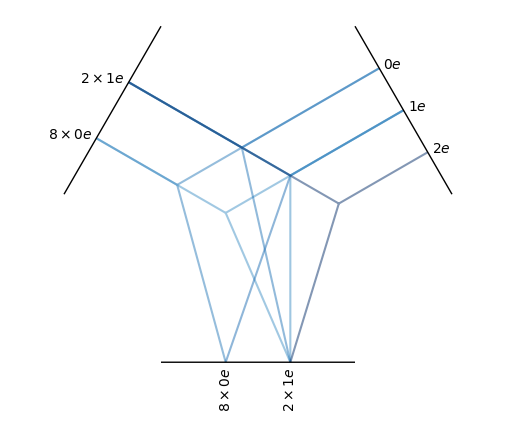

In [5]:
tp = o3.FullyConnectedTensorProduct(
    irreps_in1=irrep_seq[2],
    irreps_in2=sh_irreps,
    irreps_out=irrep_seq[3]
)
print(tp)
tp.visualize()

We also used the `e3nn.o3` tensor product functions to calculate the irrep sequences for the SO(3) group. An example is shown above.

### Evaluation of experiments
We will use the proportion of generated ligands out of 40 samples that have RMSD < 2, and RMSD < 5 Angstroms to the ground truth as our metrics of evaluation. A higher proportion of RMSD below a threshold is a more accurate model. We do not consider the filtered RMSD < 2, RMSD < 5, which requires the confidence model to rank the 40 samples for each protein ligand pair to get the highest confidence generated ligand. Training the confidence model is not in the scope of this project and use the published confidence model provided by DiffDock. Hence, our evaluations generally do not consider the filtered RMSD metrics.

We will evaluated training and validation performance over the training epochs by running the DiffDock model and logging metrics with wandb. The results have been extracted from wandb and are shown below.

## Summary of experimental set ups

We ran the following set ups using the "Training DiffDock" script provided above with these additional flags. The proportion of RMSD < 2 and RMSD < 5 for the validation set are plotted below.

For each of these experiments we scaled down the model to minimise overfitting with `--ns 8` `--nv 2`. The labels of these experiments are also given. The RMSD metrics can be found in `results/`
* `use_order_repr 0 --use_sh_lmax 2` = lmax0_ns8_nv2
* `use_order_repr 1 --use_sh_lmax 2` = lmax1_ns8_nv2
* `use_order_repr 2 --use_sh_lmax 3` = lmax2_shlmax3_ns8_nv2
* `use_order_repr 3 --use_sh_lmax 4` = lmax3_shlmax4_ns8_nv2
* `use_order_repr 1 --use_sh_lmax 2 --no_odd_irreps --no_odd_tor_irreps` = lmax1_ns8_nv2_1e_0e
* `use_order_repr 1 --use_sh_lmax 2 --no_odd_irreps --no_even_tor_irreps` = lmax1_ns8_nv2_1e_0o
* `use_order_repr 1 --use_sh_lmax 2 --no_even_irreps --no_odd_tor_irreps` = lmax1_ns8_nv2_1o_0e
* `use_order_repr 1 --use_sh_lmax 2 --no_even_irreps --no_even_tor_irreps` = lmax1_ns8_nv2_1o_0o
* `use_order_repr 1 --use_sh_lmax 2 --use_1o_translations_1e_rotations --no_odd_tor_irreps` = lmax1_shlmax2_ns8_nv2_1o_trans_1e_rot_0e_tor

We also ran some weight-controlled experiments for direct comparison of output results. These flags were used.
* `use_order_repr 0 --use_sh_lmax 2 --nv 6 --ns 24` = WC_lmax0_shlmax2_nv6_ns24
* `use_order_repr 1 --use_sh_lmax 2 --nv 5 --ns 18` = WC_lmax1_shlmax2_nv5_ns18
* `use_order_repr 2 --use_sh_lmax 3 --nv 4 --ns 15` = WC_lmax2_shlmax3_nv4_ns15
* `use_order_repr 3 --use_sh_lmax 4 --nv 3 --ns 14` = WC_lmax3_shlmax4_nv3_ns14
All of these models have a similar number of parameters.

Finally to run the SO(3) experiments we used the following flags:
* `use_so3 --use_order_repr 1 --use_sh_lmax 2` = WC_lmax1_shlmax2_nv2_ns9_so3, this was weight-controlled to match lmax1_ns8_nv2

## Results

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

These results are fetched from wandb and have been saved in `results/`.

In [10]:
val_rmsds_lt2 = pd.read_csv('results/updated_results/wandb_val_rmsds_lt2.csv')
val_rmsds_lt5 = pd.read_csv('results/updated_results/wandb_val_rmsds_lt5.csv')
numel_df = pd.read_csv('results/updated_results/wandb_numel.csv')
train_loss = pd.read_csv('results/updated_results/wandb_train_loss.csv')

for col in val_rmsds_lt2.columns:
    val_rmsds_lt2[f'{col}_best'] = val_rmsds_lt2[col].cummax()
for col in val_rmsds_lt5.columns:
    val_rmsds_lt5[f'{col}_best'] = val_rmsds_lt5[col].cummax()

In [3]:
for col in sorted(numel_df.columns):
    print(col)

WC_lmax0_shlmax2_nv6_ns24
WC_lmax1_shlmax2_nv2_ns9_so3
WC_lmax1_shlmax2_nv5_ns18
WC_lmax2_shlmax3_nv4_ns15
WC_lmax3_shlmax4_nv3_ns14
lmax0_ns8_nv2
lmax1_ns8_nv2
lmax1_ns8_nv2_1e_0e
lmax1_ns8_nv2_1e_0o
lmax1_ns8_nv2_1o_0e
lmax1_ns8_nv2_1o_0o
lmax1_shlmax2_ns8_nv2_1o_trans_1e_rot_0e_tor
lmax2_shlmax3_ns8_nv2
lmax3_shlmax4_ns8_nv2
numel_count


### Results: Effect of different order irreps
In this section we explore using different order irreps for by varying `l_max` which refers to the highest $l$ in the irrep sequence used in the interaction layers, and varying `sh_lmax` refers to the highest $l$ used in the spherical harmonics that were used in the tensor products with the feature vectors. The goal of this is to determine if higher order $l$ can improve model performance by increasing expressivity of the model.

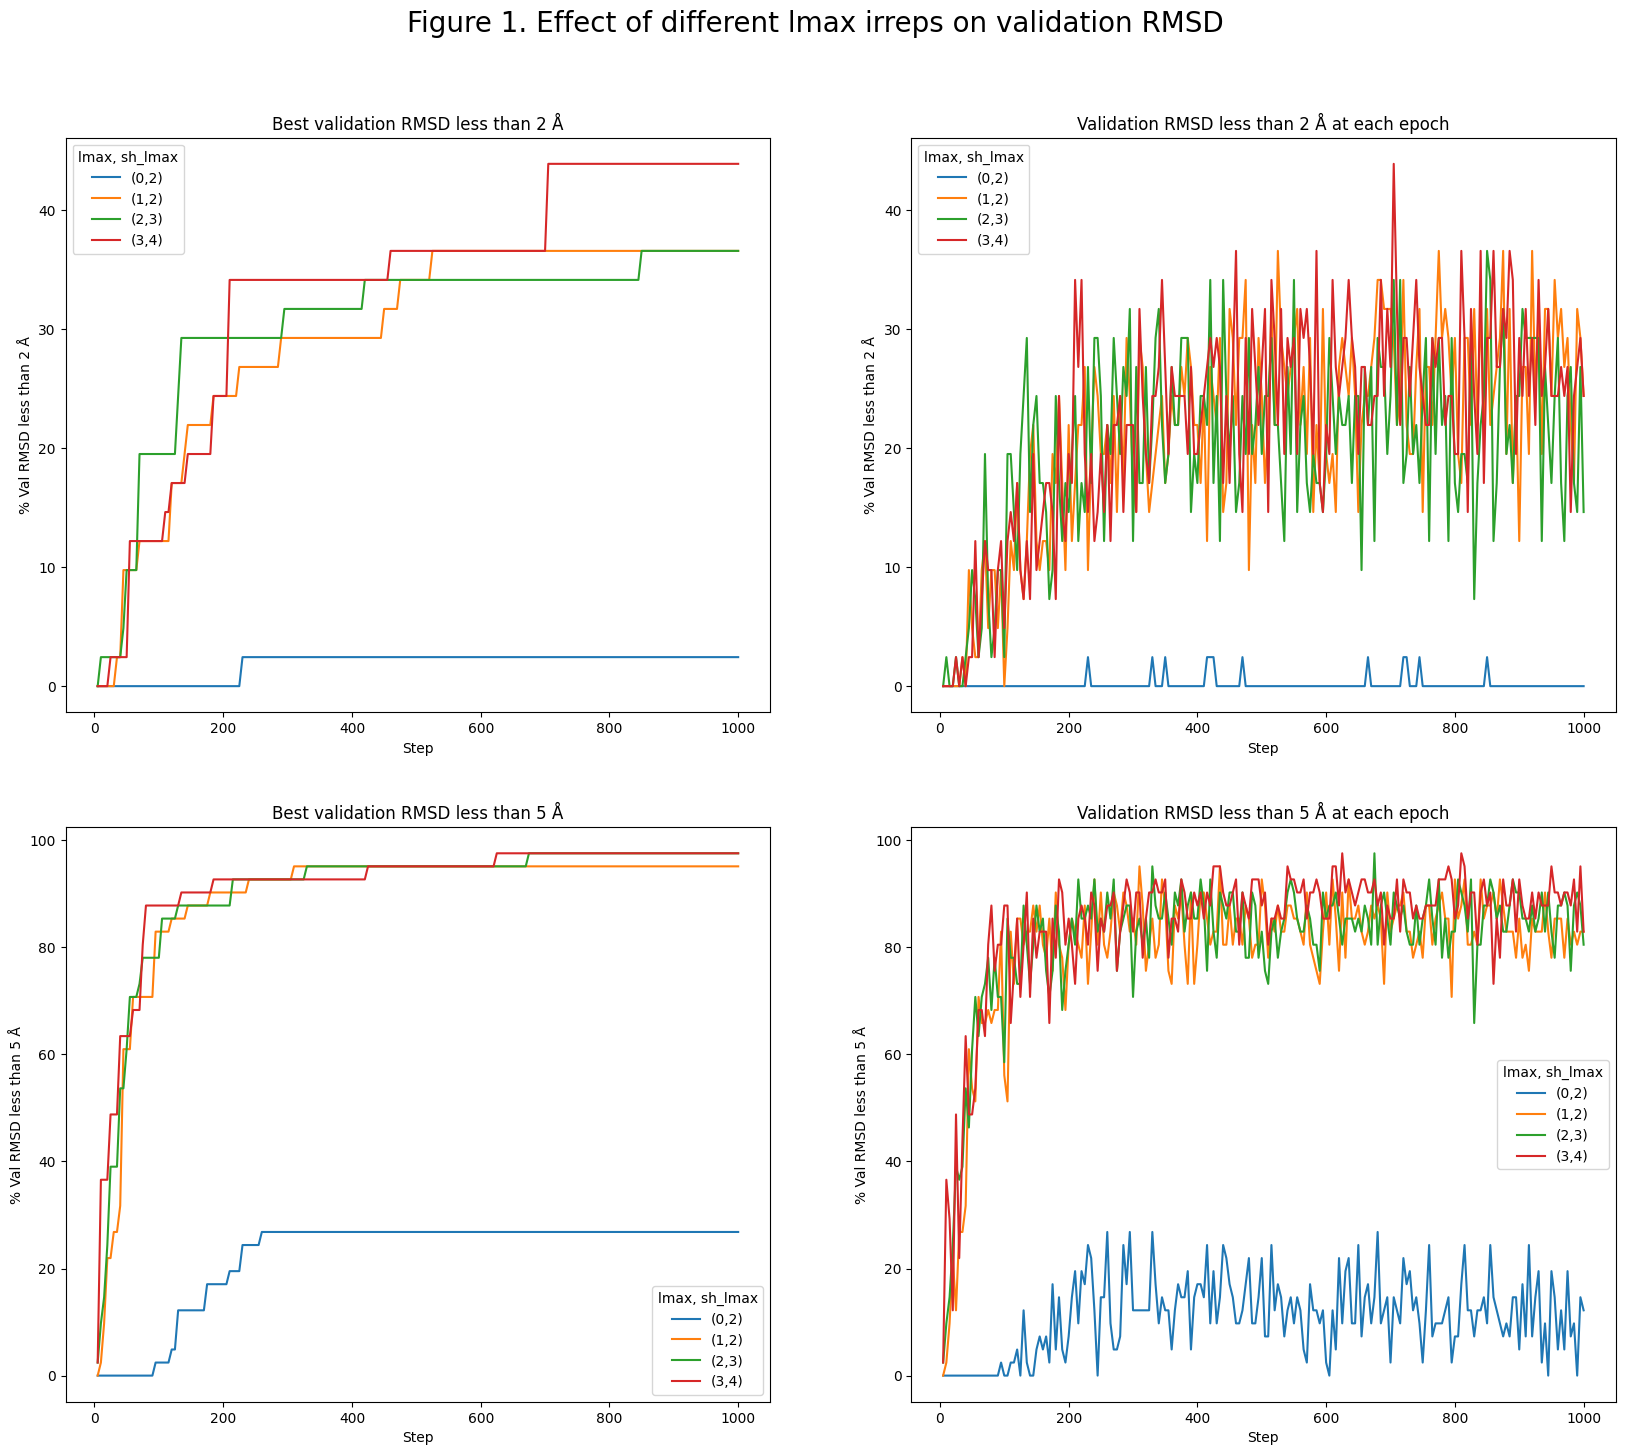

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

rmsd = 2
df = val_rmsds_lt2

suffix = "_best"
axs[0,0].plot(
    df["Step"],
    df[f"lmax0_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(0,2)"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(1,2)"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax2_shlmax3_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(2,3)"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax3_shlmax4_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(3,4)"
)
axs[0,0].set_xlabel("Step")
axs[0,0].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[0,0].set_title(f"Best validation RMSD less than {rmsd} Å")
axs[0,0].legend(title="lmax, sh_lmax")

suffix = ""
axs[0,1].plot(
    df["Step"],
    df[f"lmax0_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(0,2)"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(1,2)"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax2_shlmax3_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(2,3)"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax3_shlmax4_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(3,4)"
)
axs[0,1].set_xlabel("Step")
axs[0,1].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[0,1].set_title(f"Validation RMSD less than {rmsd} Å at each epoch")
axs[0,1].legend(title="lmax, sh_lmax")


rmsd = 5
df = val_rmsds_lt5

suffix = "_best"
axs[1,0].plot(
    df["Step"],
    df[f"lmax0_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(0,2)"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(1,2)"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax2_shlmax3_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(2,3)"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax3_shlmax4_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(3,4)"
)
axs[1,0].set_xlabel("Step")
axs[1,0].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[1,0].set_title(f"Best validation RMSD less than {rmsd} Å")
axs[1,0].legend(title="lmax, sh_lmax")

suffix = ""
axs[1,1].plot(
    df["Step"],
    df[f"lmax0_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(0,2)"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(1,2)"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax2_shlmax3_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(2,3)"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax3_shlmax4_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(3,4)"
)
axs[1,1].set_xlabel("Step")
axs[1,1].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[1,1].set_title(f"Validation RMSD less than {rmsd} Å at each epoch")
axs[1,1].legend(title="lmax, sh_lmax")

fig.suptitle("Figure 1. Effect of different lmax irreps on validation RMSD", fontsize=20)
fig.subplots_adjust(top=0.9)
plt.show()

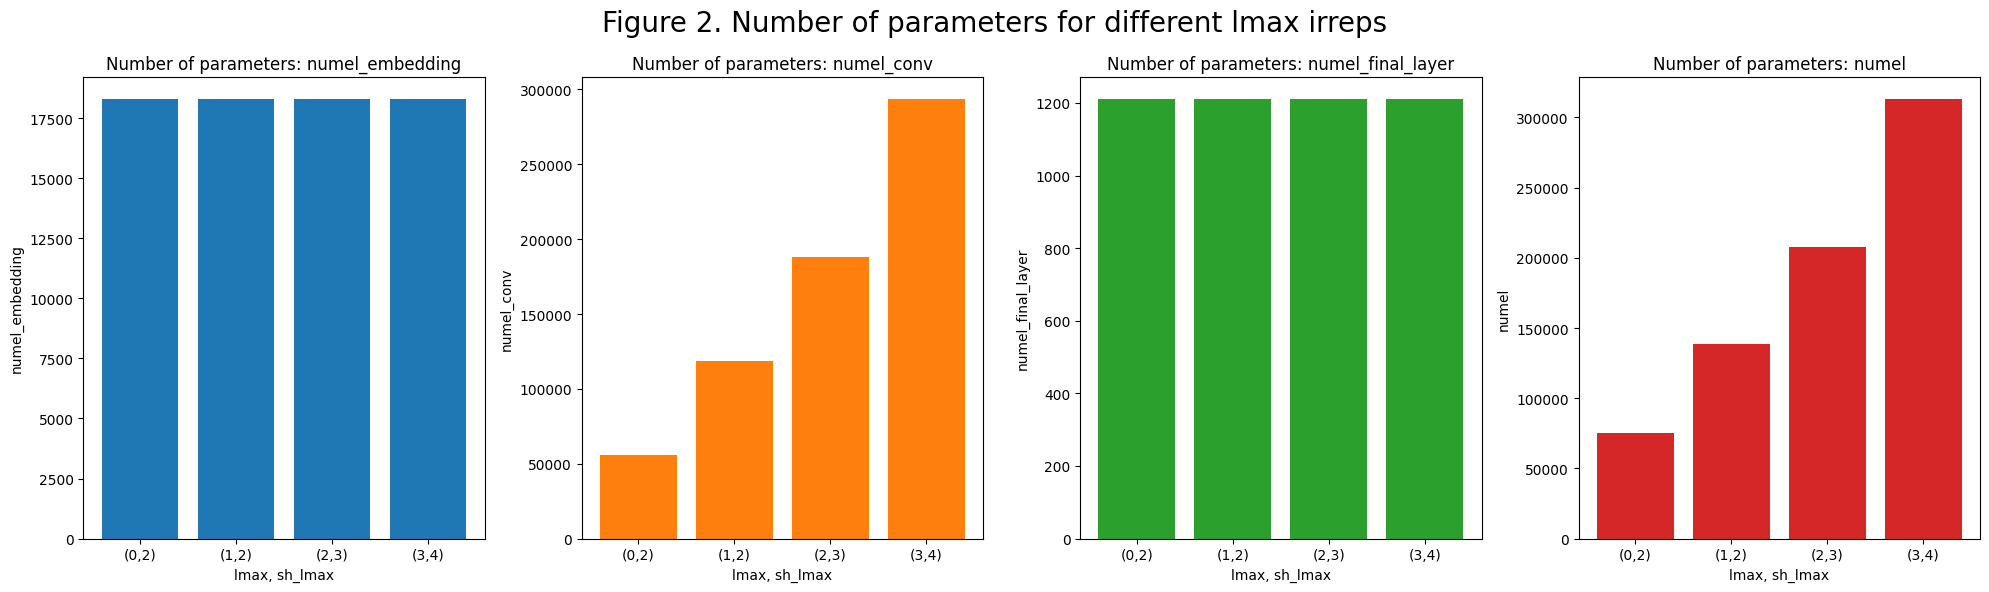

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

colour = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for idx, val in enumerate(numel_df.numel_count):
    axs[idx].bar(
        ['(0,2)', '(1,2)', '(2,3)', '(3,4)'],
        numel_df[numel_df.numel_count==val][['lmax0_ns8_nv2', 'lmax1_ns8_nv2', 'lmax2_shlmax3_ns8_nv2', 'lmax3_shlmax4_ns8_nv2']].values[0],
        color=colour[idx]
    )
    axs[idx].set_xlabel("lmax, sh_lmax")
    axs[idx].set_ylabel(val)
    axs[idx].set_title(f"Number of parameters: {val}")
fig.suptitle("Figure 2. Number of parameters for different lmax irreps", fontsize=20)
fig.tight_layout()


In [13]:
test_lmax_shlmax_results = [
    ["lmax", "sh_lmax", "Test % RMSD < 2"],
    [0, 2, 0.58],
    [1, 2, 33.78],
    [2, 3, 35.29],
    [3, 4, 33.78]
]
print("Test results for different lmax and sh_lmax irreps")
pd.DataFrame(test_lmax_shlmax_results[1:], columns=test_lmax_shlmax_results[0])

Test results for different lmax and sh_lmax irreps


,lmax,sh_lmax,Test % RMSD < 2
0,0,2,0.58
1,1,2,33.78
2,2,3,35.29
3,3,4,33.78


From the above validation results (Figure 1) and test results we can see that:
* $l_{max}=0, shl_{max}=2$ performs the worst in both measures of RMSD. This was expected as it is an invariant model and therefore the output does not change with respect to transformations in SE(3). However, this model is not weight normalised, that is this model is also less expressive as it has fewer parameters (see Figure 2. Number of parameters: numel). We will run experiments that account for the difference in number of parameters as well in the next section.
* $l_{max}=1, shl_{max}=2$ this is the default irrep sequence in DiffDock and performs quite well as expected.
* $(l_{max}=2, shl_{max}=3), (l_{max}=3, shl_{max}=4)$ performs slightly better than $l_{max}=0, shl_{max}=2$ when referring to validation and test time results. The addition of the higher order irreps slows down training time as the higher order representations are also combinatorially larger. Hence they were trained for 3 days instead of 2 days. It is unclear if the higher order representations improve the model or if it is because of the larger number of parameters as seen in Figure 2.

For more conclusive evidence on the effects of $l_{max}$ and $shl_{max}$ on model performance the weight-controlled results are shown in the next section.

### Results: Effect of different order irreps (weight controlled)

Since models with higher $l_{max}$ have more parameters, it is natural to question whether their improved performance can be attributed to their increased angular resolution, or trivially arises simply due to their larger capacity.  Taking inspiration from [4], we perform a set of weight-controlled experiments, where we fix the total number of parameters and vary the maximum spherical harmonic degree $l_{max}$ to investigate the effect of angular resolution on the performance of the diffdock model. Specifically, we compare the performance of models with different $l_{max}$ but the same number of parameters on the task of predicting the binding affinity between a protein and a ligand.

#### Investigating parameter contributions

Firstly, we investigate the relationship between $l_{max}$ and parameter count. The Figure 2 summarises our parameter count results for fixed `ns`, `nv` for each component of the model (embedding, convolution, final_layer) and numel which sums all three. An initial naive hypothesis might be that sum of the the parameter counts of the convolutional layers would scale proportionally to $2 l_{max} + 1$, since this is the number of entries of the largest permitted irrep. 

However, as shown in Figure 2, the relationship does not follow this trend. This is because the layers convolutional layers do not always use all available irreps (see the definitions of `irrep_seq` for each irrep above). Note for example that the first convolutional layer always takes an a scalar input, even for $l_{max} > 1$. Moreover, the relationship between $l_{max}$ and parameter counts is further complicated by the convolutional layers, which introduce a non-linear relationship between input/output dimensions and number of parameters. In this section we manipulate `ns, nv` to achieve approximately equal number of parameters for each model in order to better directly compare model performance across different $l_{max}$ and $shl_{max}$. 

Figure 2 shows the relationship between $l_{max}, shl_{max}$ and number of parameters (elements) for fixed `ns, nv`. Note the different scales on the y-axis, the convolutional parameters (middle) actually heavily outweigh the other two parameters. We can also see this relationship is non-linear. 

To perform a weight-controlled experiment, we empirically discovered `ns` and `nv` values for each value of $l_{max}$ that resulted in as close as possible to equal parameter counts. (Note that `ns` and `nv` must be integers, so the counts cannot be exactly equal.)

The data and plot in Figure 4 and 5 shows our final setup for the weight controlled experiment (shown as a stacked bar chart to show that the convolutional parameters make up the majority).

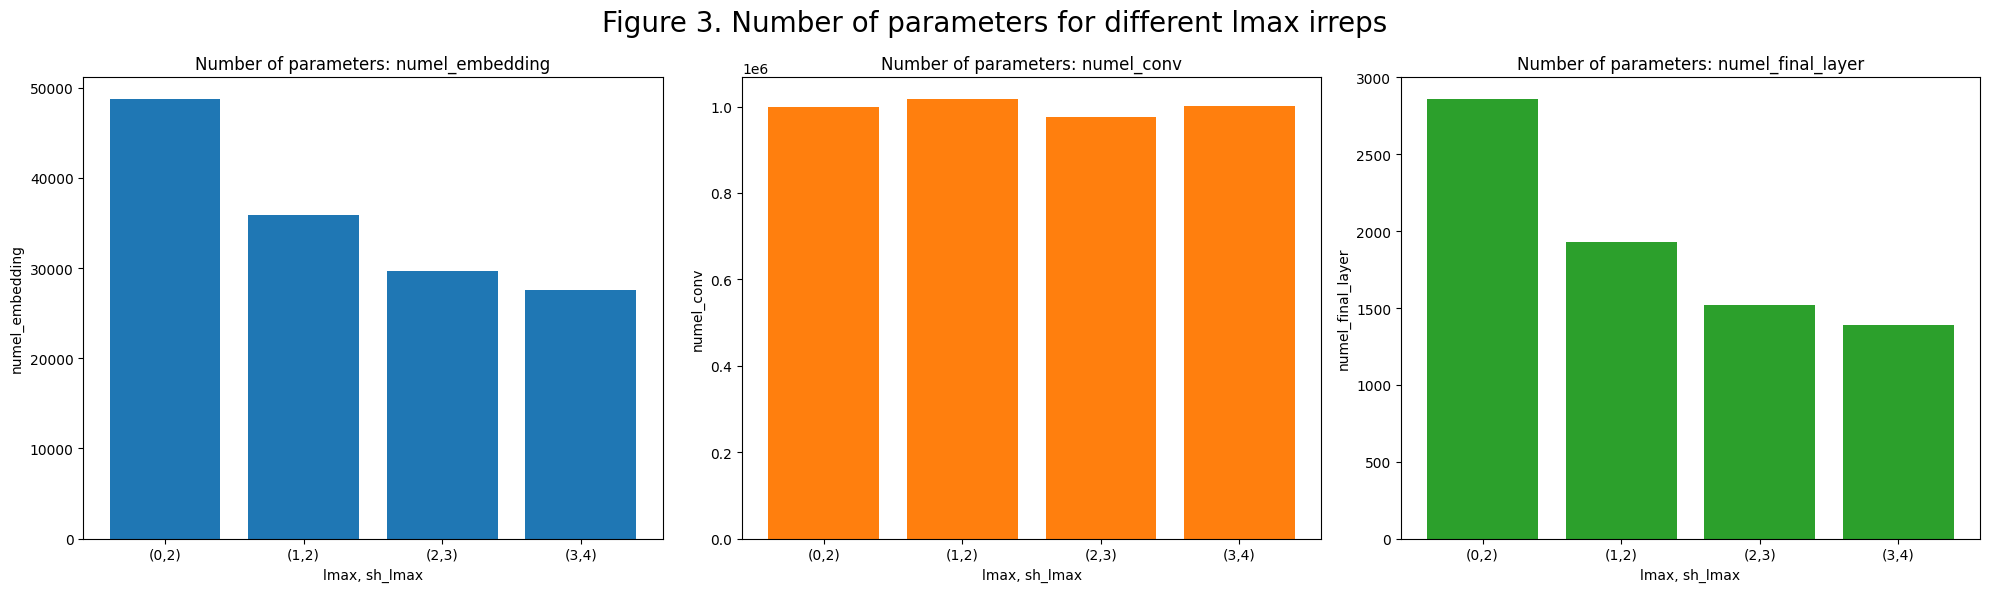

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

colour = ["tab:blue", "tab:orange", "tab:green"]
for idx, val in enumerate(numel_df.numel_count[:3]):
    axs[idx].bar(
        ['(0,2)', '(1,2)', '(2,3)', '(3,4)'],
        numel_df[numel_df.numel_count==val][[
            'WC_lmax0_shlmax2_nv6_ns24',
            'WC_lmax1_shlmax2_nv5_ns18',
            'WC_lmax2_shlmax3_nv4_ns15',
            'WC_lmax3_shlmax4_nv3_ns14',
            ]].values[0],
        color=colour[idx]
    )
    axs[idx].set_xlabel("lmax, sh_lmax")
    axs[idx].set_ylabel(val)
    axs[idx].set_title(f"Number of parameters: {val}")
fig.suptitle("Figure 3. Number of parameters for different lmax irreps", fontsize=20)
fig.tight_layout()

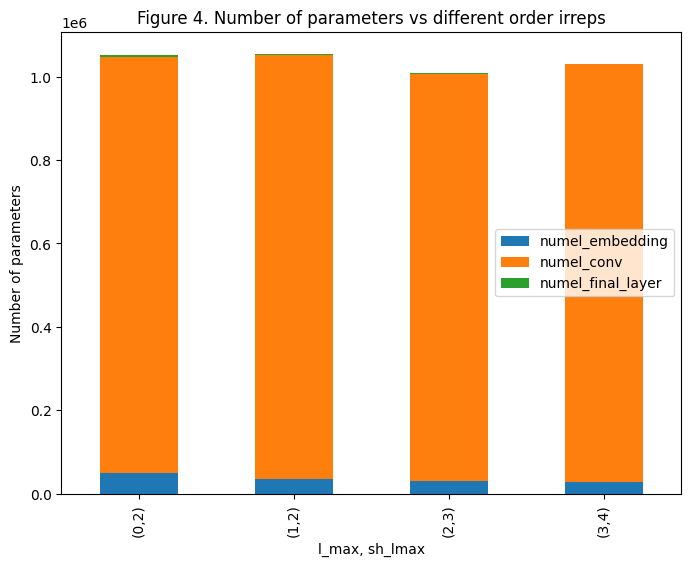

In [5]:
wc_numel = numel_df[['numel_count',
            'WC_lmax0_shlmax2_nv6_ns24',
            'WC_lmax1_shlmax2_nv5_ns18',
            'WC_lmax2_shlmax3_nv4_ns15',
            'WC_lmax3_shlmax4_nv3_ns14',
            ]].T
wc_numel.columns = wc_numel.iloc[0]
wc_numel.drop(wc_numel.index[0], inplace=True)
wc_numel

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))

wc_numel['numel_embedding'].plot.bar(ax=ax, stacked=True, label='numel_embedding', color='tab:blue')
wc_numel['numel_conv'].plot.bar(ax=ax, stacked=True, label='numel_conv', color='tab:orange', bottom=wc_numel['numel_embedding'])
wc_numel['numel_final_layer'].plot.bar(ax=ax, stacked=True, label='numel_final_layer', color='tab:green', bottom=wc_numel['numel_embedding'] + wc_numel['numel_conv'])
ax.xaxis.set_ticklabels(['(0,2)', '(1,2)', '(2,3)', '(3,4)'])

# Add legend
plt.legend()

# Set labels
ax.set_xlabel("l_max, sh_lmax")
ax.set_ylabel("Number of parameters")
plt.title("Figure 4. Number of parameters vs different order irreps")

plt.show()

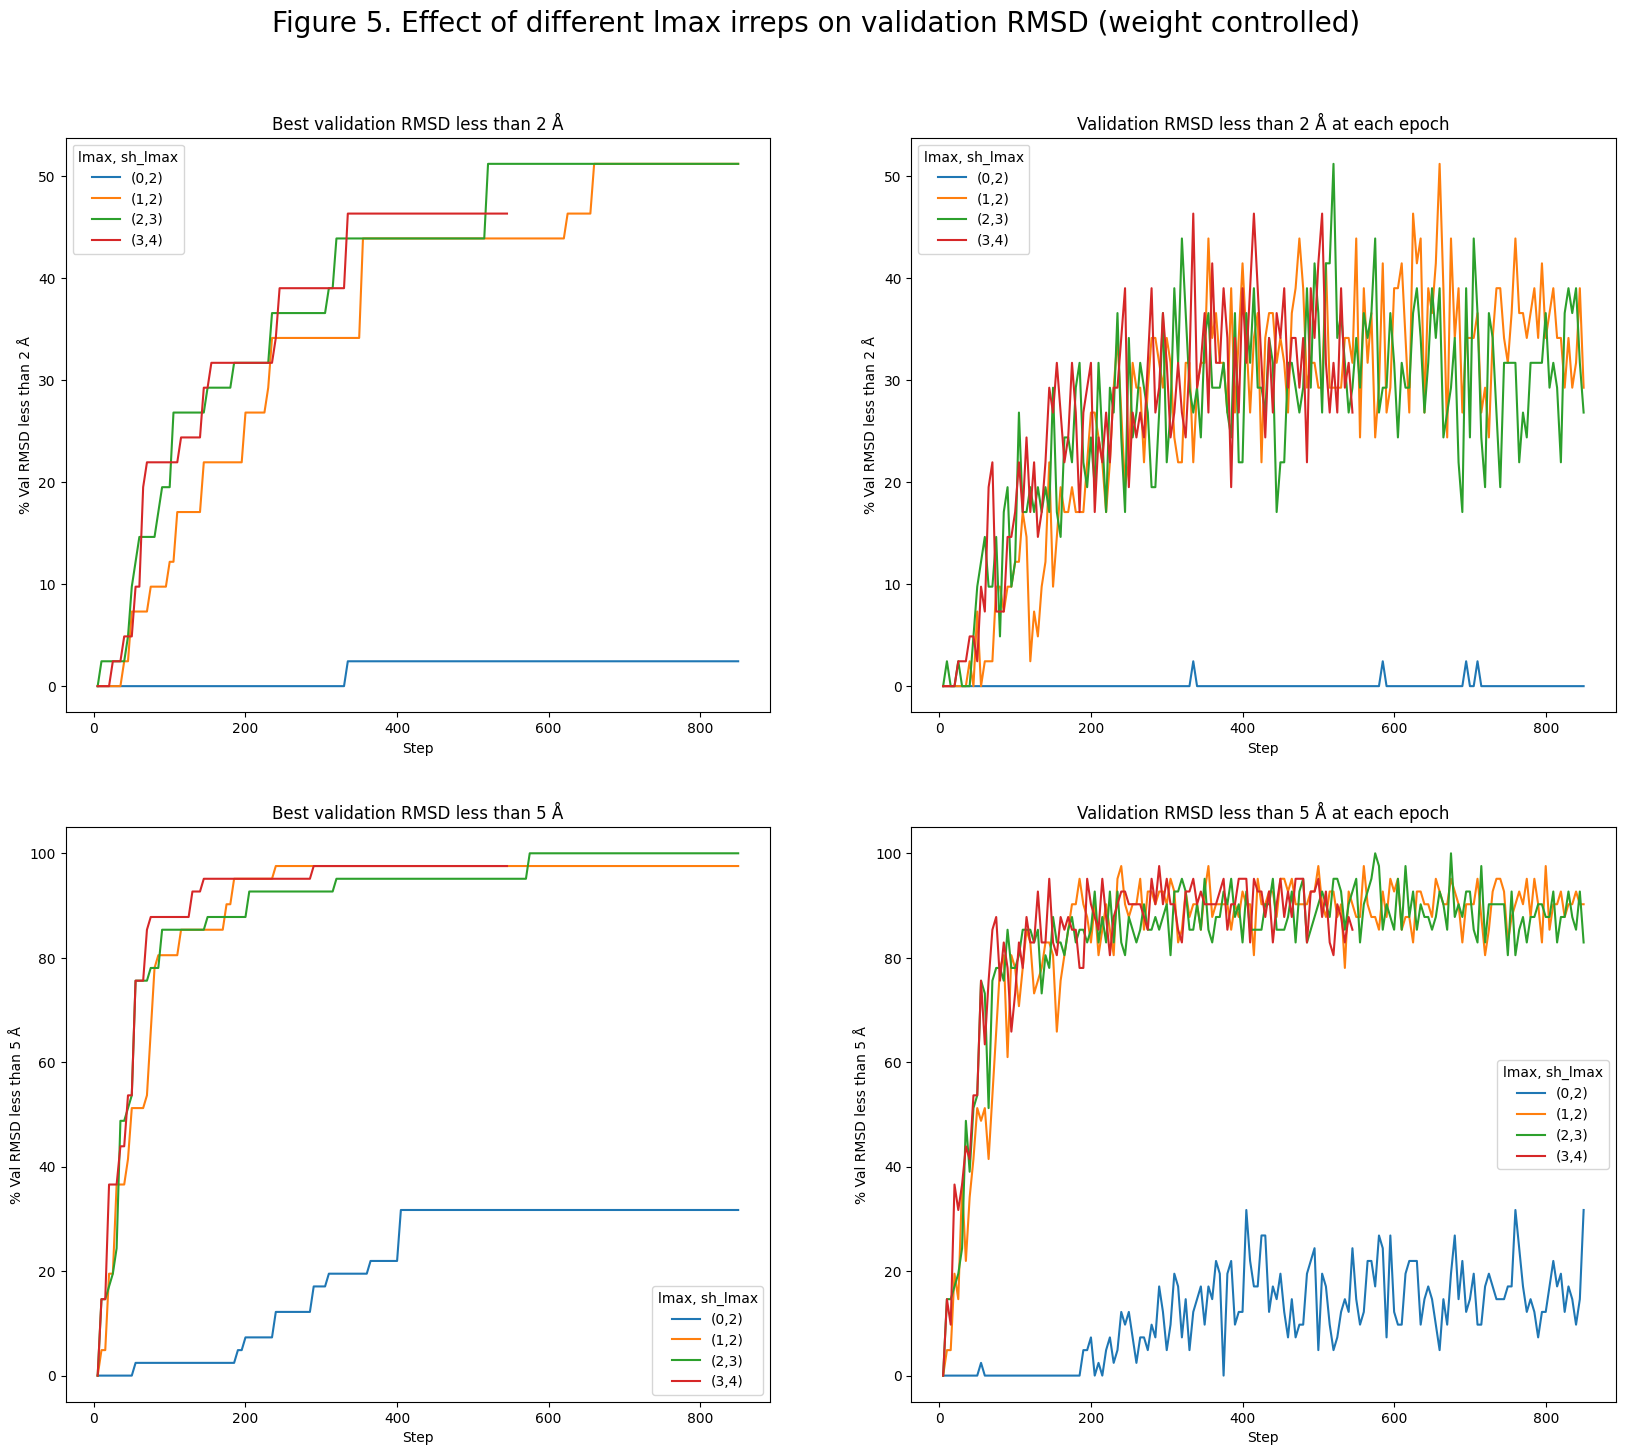

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

rmsd = 2
df = val_rmsds_lt2

suffix = "_best"
axs[0,0].plot(
    df["Step"],
    df[f"WC_lmax0_shlmax2_nv6_ns24 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(0,2)"
)
axs[0,0].plot(
    df["Step"],
    df[f"WC_lmax1_shlmax2_nv5_ns18 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(1,2)"
)
axs[0,0].plot(
    df["Step"],
    df[f"WC_lmax2_shlmax3_nv4_ns15 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(2,3)"
)
axs[0,0].plot(
    df["Step"],
    df[f"WC_lmax3_shlmax4_nv3_ns14 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(3,4)"
)
axs[0,0].set_xlabel("Step")
axs[0,0].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[0,0].set_title(f"Best validation RMSD less than {rmsd} Å")
axs[0,0].legend(title="lmax, sh_lmax")

suffix = ""
axs[0,1].plot(
    df["Step"],
    df[f"WC_lmax0_shlmax2_nv6_ns24 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(0,2)"
)
axs[0,1].plot(
    df["Step"],
    df[f"WC_lmax1_shlmax2_nv5_ns18 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(1,2)"
)
axs[0,1].plot(
    df["Step"],
    df[f"WC_lmax2_shlmax3_nv4_ns15 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(2,3)"
)
axs[0,1].plot(
    df["Step"],
    df[f"WC_lmax3_shlmax4_nv3_ns14 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(3,4)"
)
axs[0,1].set_xlabel("Step")
axs[0,1].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[0,1].set_title(f"Validation RMSD less than {rmsd} Å at each epoch")
axs[0,1].legend(title="lmax, sh_lmax")


rmsd = 5
df = val_rmsds_lt5

suffix = "_best"
axs[1,0].plot(
    df["Step"],
    df[f"WC_lmax0_shlmax2_nv6_ns24 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(0,2)"
)
axs[1,0].plot(
    df["Step"],
    df[f"WC_lmax1_shlmax2_nv5_ns18 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(1,2)"
)
axs[1,0].plot(
    df["Step"],
    df[f"WC_lmax2_shlmax3_nv4_ns15 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(2,3)"
)
axs[1,0].plot(
    df["Step"],
    df[f"WC_lmax3_shlmax4_nv3_ns14 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(3,4)"
)
axs[1,0].set_xlabel("Step")
axs[1,0].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[1,0].set_title(f"Best validation RMSD less than {rmsd} Å")
axs[1,0].legend(title="lmax, sh_lmax")

suffix = ""
axs[1,1].plot(
    df["Step"],
    df[f"WC_lmax0_shlmax2_nv6_ns24 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(0,2)"
)
axs[1,1].plot(
    df["Step"],
    df[f"WC_lmax1_shlmax2_nv5_ns18 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(1,2)"
)
axs[1,1].plot(
    df["Step"],
    df[f"WC_lmax2_shlmax3_nv4_ns15 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(2,3)"
)
axs[1,1].plot(
    df["Step"],
    df[f"WC_lmax3_shlmax4_nv3_ns14 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="(3,4)"
)
axs[1,1].set_xlabel("Step")
axs[1,1].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[1,1].set_title(f"Validation RMSD less than {rmsd} Å at each epoch")
axs[1,1].legend(title="lmax, sh_lmax")

fig.suptitle("Figure 5. Effect of different lmax irreps on validation RMSD (weight controlled)", fontsize=20)
fig.subplots_adjust(top=0.9)
plt.show()

In [7]:
test_lmax_shlmax_wc_results = [
    ['lmax', 'sh_lmax', 'WC Test % RMSD < 2'],
    [0, 2, 0.93],
    [1, 2, 45.11],
    [2, 3, 44.59],
    [3, 4, 45.47]]
print("Test results for different lmax and sh_lmax irreps, weight-controlled")
pd.DataFrame(test_lmax_shlmax_wc_results[1:], columns=test_lmax_shlmax_wc_results[0])

Test results for different lmax and sh_lmax irreps, weight-controlled


,lmax,sh_lmax,WC Test % RMSD < 2
0,0,2,0.93
1,1,2,45.11
2,2,3,44.59
3,3,4,45.47


From Figure 5 we can see that when controlling for different number of parameters, the model with $l_{max}=1$ performs the best. This is consistent with the results in the previous section. We can also see that the model with $l_{max}=0$ performs the worst. This is also consistent with the results in the previous section. Hence in terms of accuracy of outputted predictions, higher irreps do not provide much benefit. This is inline with work from Batzner et al. [4] where they saw only marginal improvements with higher order $l$ in contrast Owen et al. [8] saw significant improvements with higher order $l$ up to 3 in their experiments. We hypothesise this is because protein-ligand docking is a relatively low symmetry problem, like the organic molecules from Batzner et al. [4], and not a high symmetry problem like the crystal structures from Owen et al. [8].

Higher order irreps do lead to more efficient training. In Figure 6 we look at training loss, showing that higher l_{max} values leader to faster decreases in training loss, with returns diminishing as l_{max} increases. We expect we should also see similar trends in performance v.s. data set size as Figure 5 in Batzner et al. [4] where higher order irreps also had a higher learning efficiency. However, we did not have the capacity to run these experiments.

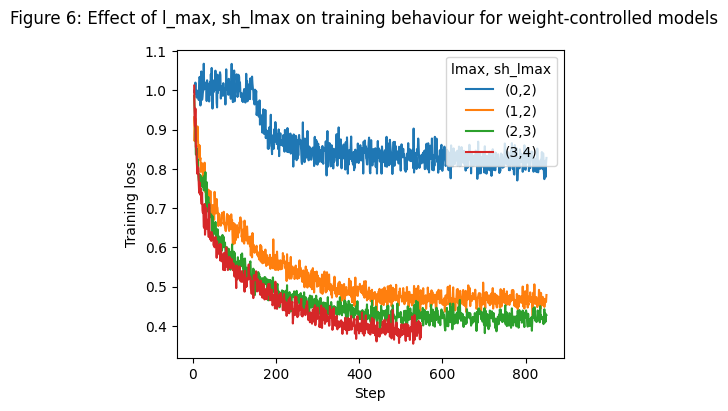

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

df = train_loss

ax.plot(
    df["Step"],
    df['WC_lmax0_shlmax2_nv6_ns24 - train_loss'],
    label="(0,2)"
)
ax.plot(
    df["Step"],
    df["WC_lmax1_shlmax2_nv5_ns18 - train_loss"],
    label="(1,2)"
)
ax.plot(
    df["Step"],
    df[f"WC_lmax2_shlmax3_nv4_ns15 - train_loss"],
    label="(2,3)"
)
ax.plot(
    df["Step"],
    df[f"WC_lmax3_shlmax4_nv3_ns14 - train_loss"],
    label="(3,4)"
)

fig.suptitle("Figure 6: Effect of l_max, sh_lmax on training behaviour for weight-controlled models", fontsize=12)
ax.set_xlabel("Step")
ax.set_ylabel(f"Training loss")
ax.legend(title="lmax, sh_lmax")


### Results: Effect of different parity of output irreps
In this section we aim to provide insight into why the `1o+1e` irreps are combined for the translation and rotation scores, and why the `0o+0e` irreps are combined for the torsion scores in the final layer. The translation, rotation, and torsion scores represent linear acceleration of the center of the ligand, angular acceleration of the center of the ligand, and pseudotorque of each rotatable bond respectively. Hence, it is expected that these scores should have parity rather than a combination of both parities.

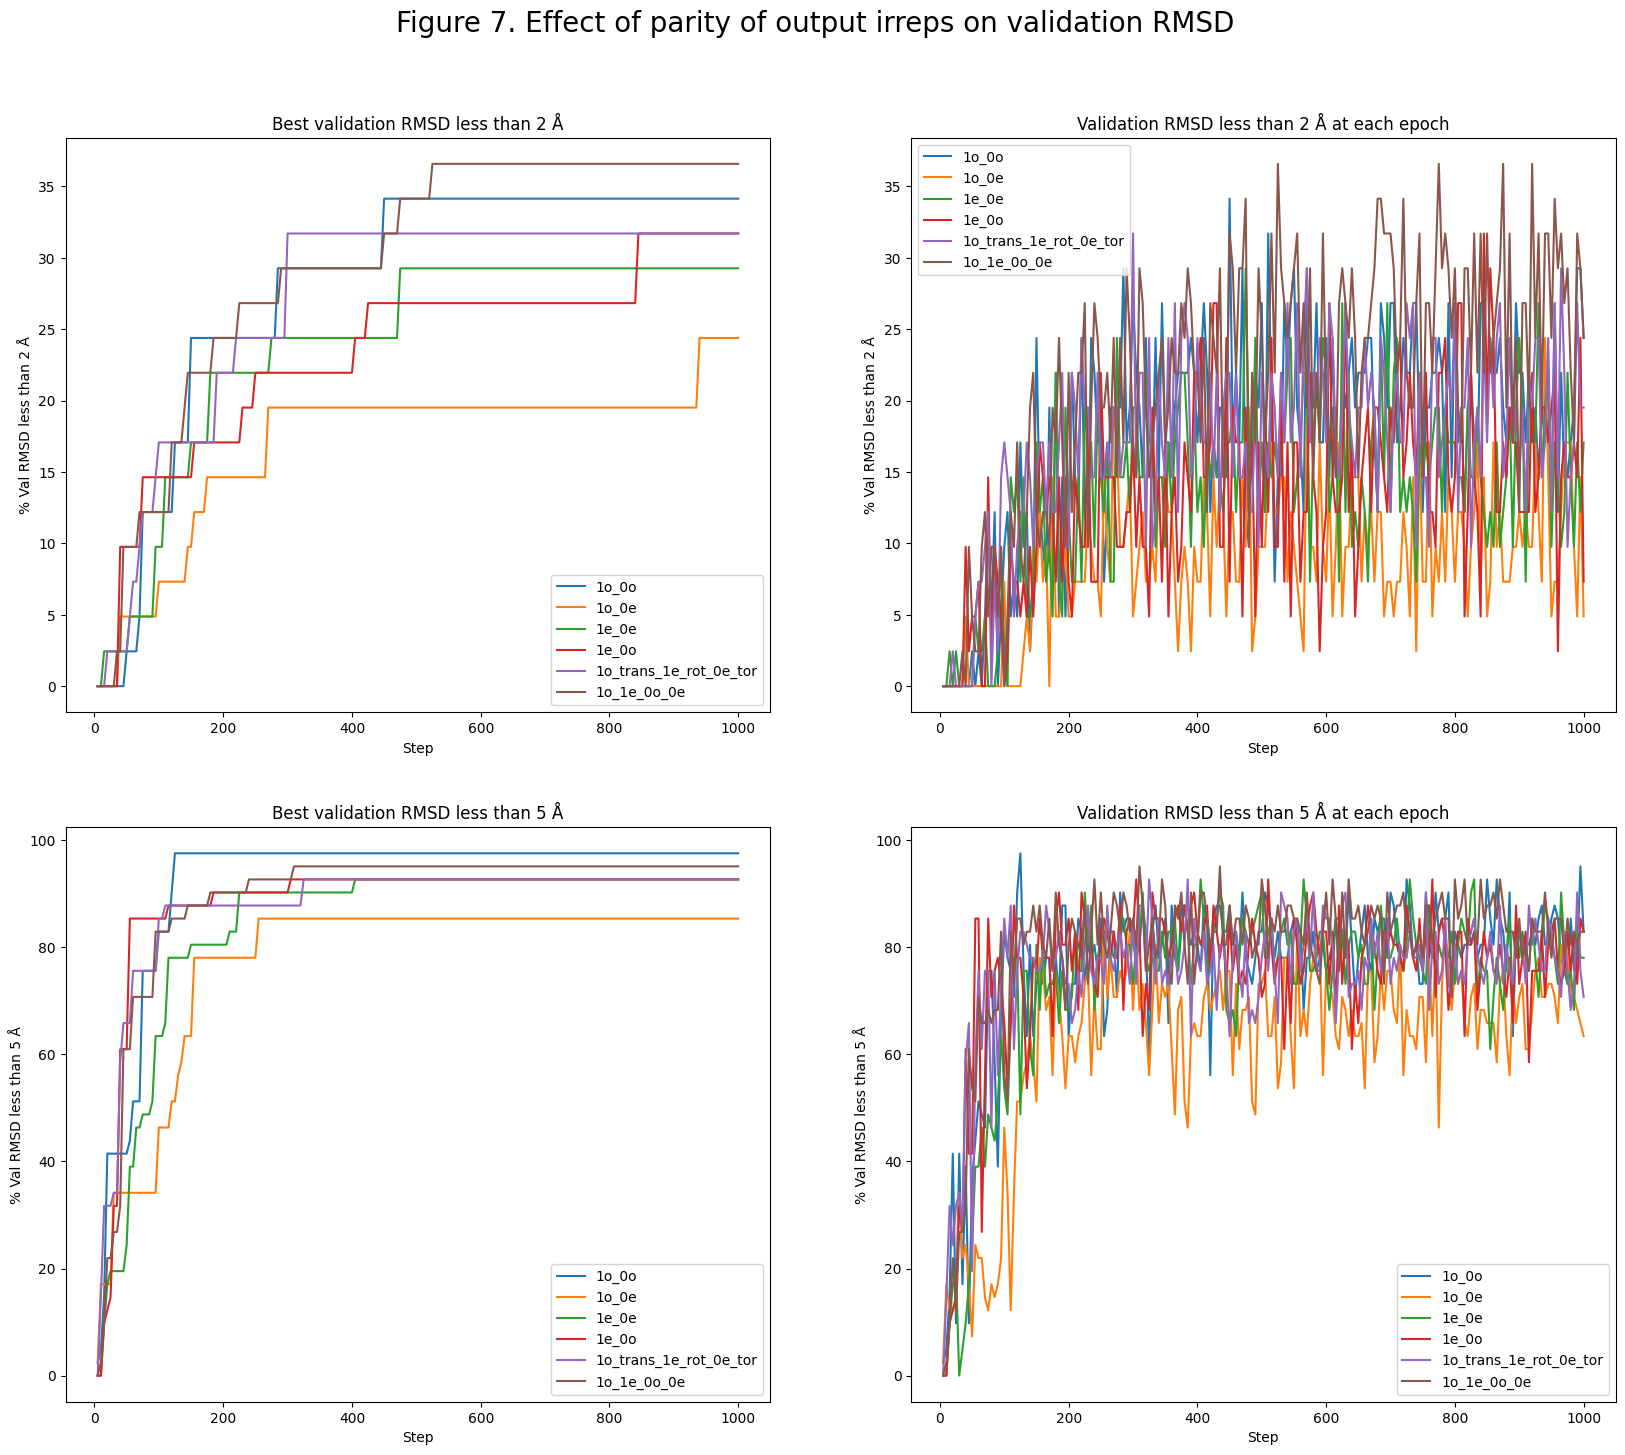

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

rmsd = 2
df = val_rmsds_lt2

suffix = "_best"
axs[0,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1o_0o - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_0o"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1o_0e - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_0e"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1e_0e - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1e_0e"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1e_0o - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1e_0o"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax1_shlmax2_ns8_nv2_1o_trans_1e_rot_0e_tor - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_trans_1e_rot_0e_tor"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_1e_0o_0e"
)
axs[0,0].set_xlabel("Step")
axs[0,0].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[0,0].set_title(f"Best validation RMSD less than {rmsd} Å")
axs[0,0].legend()

suffix = ""
axs[0,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1o_0o - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_0o"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1o_0e - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_0e"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1e_0e - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1e_0e"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1e_0o - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1e_0o"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax1_shlmax2_ns8_nv2_1o_trans_1e_rot_0e_tor - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_trans_1e_rot_0e_tor"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_1e_0o_0e"
)
axs[0,1].set_xlabel("Step")
axs[0,1].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[0,1].set_title(f"Validation RMSD less than {rmsd} Å at each epoch")
axs[0,1].legend()


rmsd = 5
df = val_rmsds_lt5

suffix = "_best"
axs[1,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1o_0o - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_0o"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1o_0e - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_0e"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1e_0e - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1e_0e"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1e_0o - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1e_0o"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax1_shlmax2_ns8_nv2_1o_trans_1e_rot_0e_tor - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_trans_1e_rot_0e_tor"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_1e_0o_0e"
)
axs[1,0].set_xlabel("Step")
axs[1,0].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[1,0].set_title(f"Best validation RMSD less than {rmsd} Å")
axs[1,0].legend()

suffix = ""
axs[1,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1o_0o - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_0o"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1o_0e - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_0e"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1e_0e - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1e_0e"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2_1e_0o - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1e_0o"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax1_shlmax2_ns8_nv2_1o_trans_1e_rot_0e_tor - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_trans_1e_rot_0e_tor"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="1o_1e_0o_0e"
)
axs[1,1].set_xlabel("Step")
axs[1,1].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[1,1].set_title(f"Validation RMSD less than {rmsd} Å at each epoch")
axs[1,1].legend()

fig.suptitle("Figure 7. Effect of parity of output irreps on validation RMSD", fontsize=20)
fig.subplots_adjust(top=0.9)
plt.show()

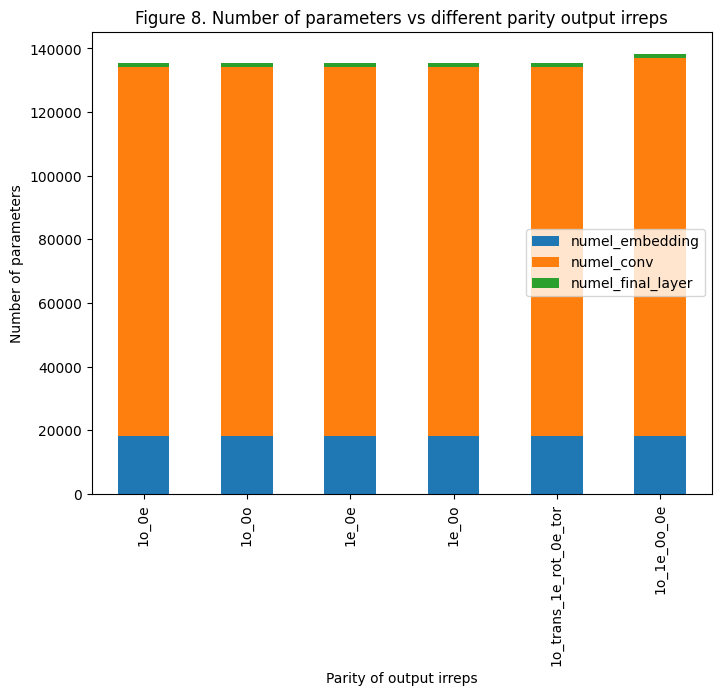

In [91]:
wc_numel = numel_df[['numel_count',
            'lmax1_ns8_nv2_1o_0e',
            'lmax1_ns8_nv2_1o_0o',
            'lmax1_ns8_nv2_1e_0e',
            'lmax1_ns8_nv2_1e_0o',
            'lmax1_shlmax2_ns8_nv2_1o_trans_1e_rot_0e_tor',
            'lmax1_ns8_nv2'
            ]].T
wc_numel.columns = wc_numel.iloc[0]
wc_numel.drop(wc_numel.index[0], inplace=True)
wc_numel

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))

wc_numel['numel_embedding'].plot.bar(ax=ax, stacked=True, label='numel_embedding', color='tab:blue')
wc_numel['numel_conv'].plot.bar(ax=ax, stacked=True, label='numel_conv', color='tab:orange', bottom=wc_numel['numel_embedding'])
wc_numel['numel_final_layer'].plot.bar(ax=ax, stacked=True, label='numel_final_layer', color='tab:green', bottom=wc_numel['numel_embedding'] + wc_numel['numel_conv'])
ax.xaxis.set_ticklabels(['1o_0e', '1o_0o', '1e_0e', '1e_0o', '1o_trans_1e_rot_0e_tor', '1o_1e_0o_0e'])

# Add legend
plt.legend()

# Set labels
ax.set_xlabel("Parity of output irreps")
ax.set_ylabel("Number of parameters")
plt.title("Figure 8. Number of parameters vs different parity output irreps")

plt.show()

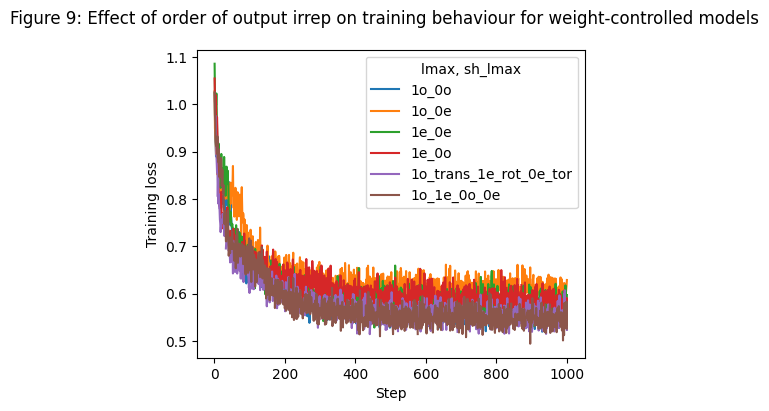

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

df = train_loss

ax.plot(
    df["Step"],
    df["lmax1_ns8_nv2_1o_0o - train_loss"],
    label="1o_0o"
)
ax.plot(
    df["Step"],
    df["lmax1_ns8_nv2_1o_0e - train_loss"],
    label="1o_0e"
)
ax.plot(
    df["Step"],
    df["lmax1_ns8_nv2_1e_0e - train_loss"],
    label="1e_0e"
)
ax.plot(
    df["Step"],
    df["lmax1_ns8_nv2_1e_0o - train_loss"],
    label="1e_0o"
)
ax.plot(
    df["Step"],
    df["lmax1_shlmax2_ns8_nv2_1o_trans_1e_rot_0e_tor - train_loss"],
    label="1o_trans_1e_rot_0e_tor"
)
ax.plot(
    df["Step"],
    df["lmax1_ns8_nv2 - train_loss"],
    label="1o_1e_0o_0e"
)

fig.suptitle("Figure 9: Effect of order of output irrep on training behaviour for weight-controlled models", fontsize=12)
ax.set_xlabel("Step")
ax.set_ylabel("Training loss")
ax.legend(title="lmax, sh_lmax")
plt.show()

In [11]:
test_parity_results = [
    ['Translation output irreps', 'Rotation output irreps', 'Torsion output irreps', '% RMSD < 2', '% RMSD < 5'],
    ['1o+1e', '1o+1e', '0o+0e', '33.78', '85.58'],
    ['1o', '1o', '0o', '28.72', '75.87'],
    ['1o', '1o', '0e', '21.57', '71.51'],
    ['1e', '1e', '0o', '29.13', '83.37'],
    ['1e', '1e', '0e', '25.70', '79.71'],
    ['1o', '1e', '0e', '28.66', '80.17']
]

print("Test set results for parity of output irreps")
pd.DataFrame(test_parity_results[1:], columns=test_parity_results[0])

Test set results for parity of output irreps


,Translation output irreps,Rotation output irreps,Torsion output irreps,% RMSD < 2,% RMSD < 5
0,1o+1e,1o+1e,0o+0e,33.78,85.58
1,1o,1o,0o,28.72,75.87
2,1o,1o,0e,21.57,71.51
3,1e,1e,0o,29.13,83.37
4,1e,1e,0e,25.70,79.71
5,1o,1e,0e,28.66,80.17


In the above figure 7-9 `lmax = 1, sh_lmax=2` was used for all experiments. We experimented with the out irrep sequence used in the final output layer for predicting the final translation, rotation, and torsional score. The following experiments were run and their labels showon in the legend are also listed:
* `1o_0o` = `2x1o` for translation score $\in \mathbb{R}^3$ and rotation score $\in \mathbb{R}^3$ for the ligand and `1o` for the torsional score $\in \mathbb{R}$ for each torsion angle in the ligand
* `1e_0o` = `2x1e` for translation score $\in \mathbb{R}^3$ and rotation score $\in \mathbb{R}^3$ for the ligand and `1o` for the torsional score $\in \mathbb{R}$ for each torsion angle in the ligand 
* `1o_0e` = `2x1o` for translation score $\in \mathbb{R}^3$ and rotation score $\in \mathbb{R}^3$ for the ligand and `1e` for the torsional score $\in \mathbb{R}$ for each torsion angle in the ligand
* `1e_0e` = `2x1e` for translation score $\in \mathbb{R}^3$ and rotation score $\in \mathbb{R}^3$ for the ligand and `1e` for the torsional score $\in \mathbb{R}$ for each torsion angle in the ligand
* `1o_trans_1e_rot_0e_tor` = `1o` for the translation score and `1e` for the rotation score $\in \mathbb{R}^3$ for the ligand and `0e` for the torsional score $\in \mathbb{R}$ for each torsion angle in the ligand
* `1o_1e_0o_0e` = `2x1o+2x1e` for translation and rotation score $\in \mathbb{R}^3$ for the ligand and `1o+1e` for the torsional score $\in \mathbb{R}$ for each torsion angle in the ligand. This is the same as the published method.

Combining both parities `1o_1e_0o_0e`, as per the published method, still performs the best. Interestingly using the `0o` pseudoscalar produced results that were the best when restricting the parity of the output. The effects of using `1o` v.s. `1e` are not as obvious. From Figure 8 we can see that all experiments have a similar number of parameters, which largely eliminates this confounding factor. The different parities also do not have much effect on the training loss (Figure 9).

We also ran `1o_trans_1e_rot_0e_tor` which aims to use the irreps that best represent each component. The translation score represents linear acceleration of the center of the ligand and should transform as the `1o` irrep, while the rotation score is the angular acceleration of the center of the ligand and should transform as the `1e` irrep. Finally, the torsion component is the pseudotorque of each rotatable bond and should transform as the `0e` irrep. However, this experiment did not perform as well using the combination of the parities. Thus, this suggests the parities of the scores are not well defined.

The authors outline that they combine both parities because of the coarse graining of the protein, only the alpha carbons of the protein are considered by the model. Coarse graining causes the model to be unaware of the chirality of the protein as it has no knowledge of the side chains of each amino acid and their orientation. Conversely, the ligand is not coarse grained and the chirality of the ligand is known. Naturally proteins are made of L-amino acids, and under inversion, the chirality of each amino acid changes to D-amino acids. However, the model is unaware of the chirality of the amino acids; hence, under inversion the coordinates of the alpha carbons will invert but the knowledge of chirality is not present. As a result the behaviour of these scores under inversion is unclear. This is why the authors combine both parities for the translation, rotation, and torsion scores.

### Results: Using SO(3) equivariant layers instead of O(3) equivariant layers
In this section we aim to provide insight into why the authors use O(3) equivariant layers instead of SO(3) equivariant layers. With the ill-defined nature under inversion of the translation, rotation, and torsion scores, in this section we test using SO(3) irreps which do not consider inversion.

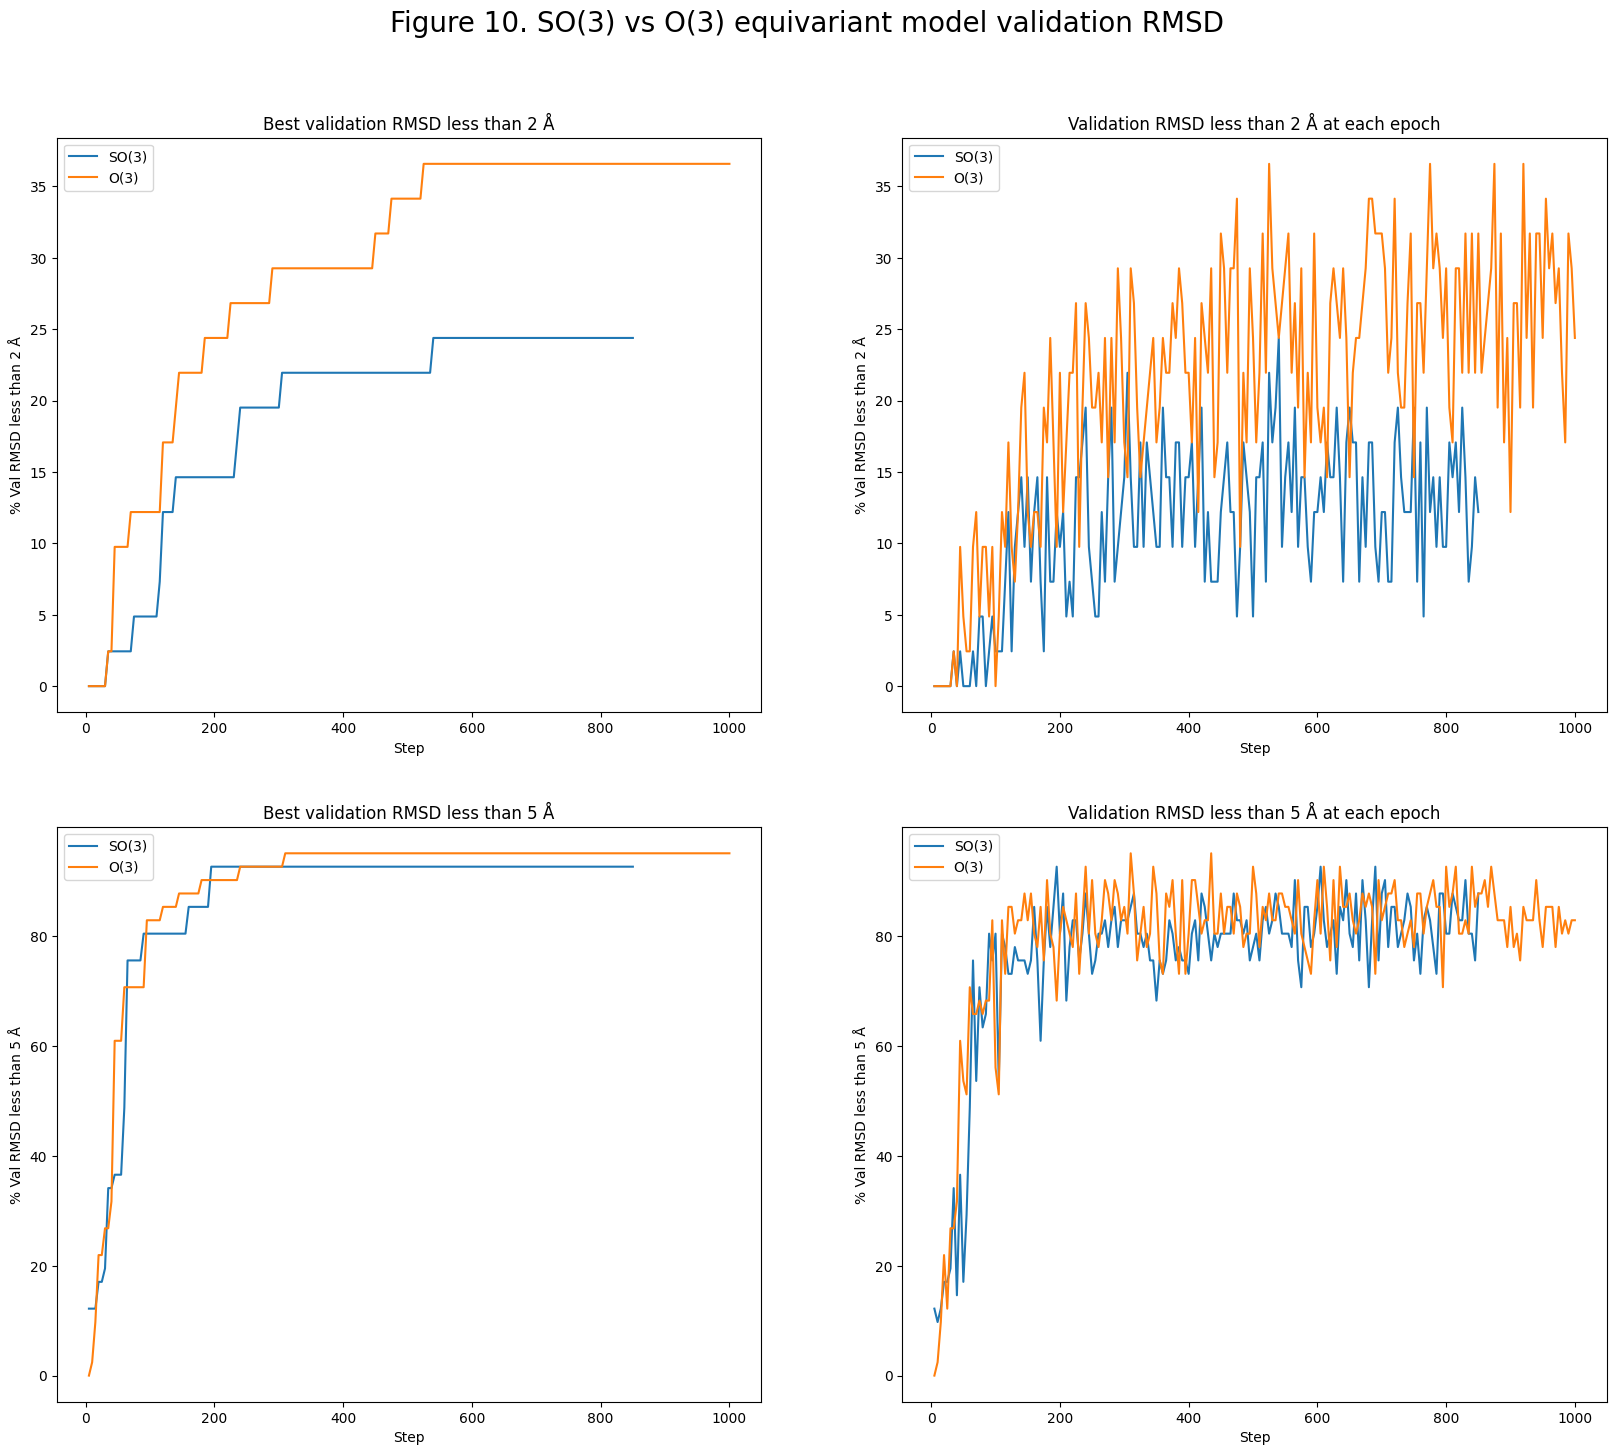

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

rmsd = 2
df = val_rmsds_lt2

suffix = "_best"
axs[0,0].plot(
    df["Step"],
    df[f"WC_lmax1_shlmax2_nv2_ns9_so3 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="SO(3)"
)
axs[0,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="O(3)"
)
axs[0,0].set_xlabel("Step")
axs[0,0].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[0,0].set_title(f"Best validation RMSD less than {rmsd} Å")
axs[0,0].legend()

suffix = ""
axs[0,1].plot(
    df["Step"],
    df[f"WC_lmax1_shlmax2_nv2_ns9_so3 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="SO(3)"
)
axs[0,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="O(3)"
)
axs[0,1].set_xlabel("Step")
axs[0,1].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[0,1].set_title(f"Validation RMSD less than {rmsd} Å at each epoch")
axs[0,1].legend()


rmsd = 5
df = val_rmsds_lt5

suffix = "_best"
axs[1,0].plot(
    df["Step"],
    df[f"WC_lmax1_shlmax2_nv2_ns9_so3 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="SO(3)"
)
axs[1,0].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="O(3)"
)
axs[1,0].set_xlabel("Step")
axs[1,0].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[1,0].set_title(f"Best validation RMSD less than {rmsd} Å")
axs[1,0].legend()

suffix = ""
axs[1,1].plot(
    df["Step"],
    df[f"WC_lmax1_shlmax2_nv2_ns9_so3 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="SO(3)"
)
axs[1,1].plot(
    df["Step"],
    df[f"lmax1_ns8_nv2 - valinf_rmsds_lt{rmsd}{suffix}"],
    label="O(3)"
)
axs[1,1].set_xlabel("Step")
axs[1,1].set_ylabel(f"% Val RMSD less than {rmsd} Å")
axs[1,1].set_title(f"Validation RMSD less than {rmsd} Å at each epoch")
axs[1,1].legend()

fig.suptitle("Figure 10. SO(3) vs O(3) equivariant model validation RMSD", fontsize=20)
fig.subplots_adjust(top=0.9)
plt.show()

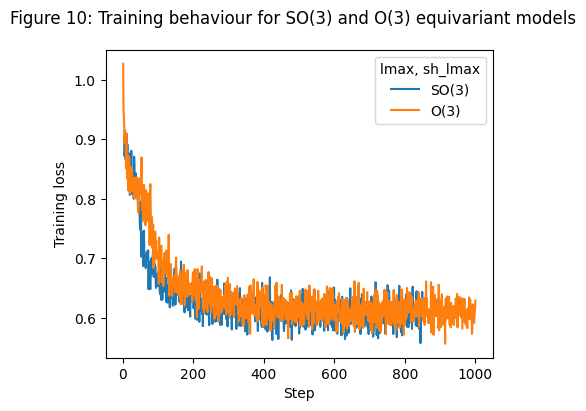

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

df = train_loss

ax.plot(
    df["Step"],
    df["WC_lmax1_shlmax2_nv2_ns9_so3 - train_loss"],
    label="SO(3)"
)
ax.plot(
    df["Step"],
    df["lmax1_ns8_nv2_1o_0e - train_loss"],
    label="O(3)"
)

fig.suptitle("Figure 10: Training behaviour for SO(3) and O(3) equivariant models", fontsize=12)
ax.set_xlabel("Step")
ax.set_ylabel("Training loss")
ax.legend(title="lmax, sh_lmax")
plt.show()

In [8]:
test_so3 = [
    ['lmax', 'sh_lmax', 'Group', 'Spherical Harmonic Irreps', '% RMSD < 2', '% RMSD < 5'],
    [1, 2, 'SO(3)', '0e+1e+2e', 26.80, 83.54],
    [1, 2, 'O(3)', '0e+1o+2e', 33.78, 85.58]
    ]

print("Test set results for SO(3) irreps")
pd.DataFrame(test_so3[1:], columns=test_so3[0])

Test set results for SO(3) irreps


,lmax,sh_lmax,Group,Spherical Harmonic Irreps,% RMSD < 2,% RMSD < 5
0,1,2,SO(3),0e+1e+2e,26.80,83.54
1,1,2,O(3),0e+1o+2e,33.78,85.58


Using SO(3) irreps does not perform better than O(3) as shown in validation and test results. This suggests that the odd parity irreps are important for the translation, rotation, and torsion scores. This suggests that the system largely behaves as expected under inversion. Despite the coarse graining of the protein and the lack of knowledge of the chirality of the amino acids. This is may be because the model knows the chirality of the ligand and the chirality of the protein binding pocket is dependent on the chirality of the ligand. This is because the ligand is bound to the protein and the chirality of the ligand will determine the chirality of the protein. Thus, the addition of inversion symmetry while not completely accurate still provides useful information to the model.

### Results: Generalisability to different proteins
Finally, in this section we test the generalisability of the model to different proteins. We test the model on 500 randomly sampled complexes from the PDBbind v2019 dataaset. The goal of this is to see how generalisable are the results of the model if it is trained on a small subset of proteins in PDBBind. In our test set we had no protein diversity and only ligand diversity, thus we test how model performance changes as we increase the protein sequence diversity. This is calculated with the pairwise sequence alignment of the protein in the diverse test set and the sequence of the protein in the training set.

In [104]:
from Bio import pairwise2
from Bio.PDB import PDBParser
from Bio import pairwise2
from Bio.Seq import Seq 
import numpy as np

In [100]:
def get_sequence(struct):
    d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
    'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
    'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
    'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    out = []
    for res in next(struct.get_chains()).get_residues():
        out.append(d3to1[res.resname])
    return Seq("".join(out))

def get_pdb(pdbid):
    data = "/n/data1/hms/dbmi/zitnik/lab/users/adf006/docking_algorithms/DiffDock/data/PDBBind_processed"
    parser = PDBParser()
    return parser.get_structure(id=pdbid, file=f"{data}/{pdbid}/{pdbid}_protein_processed.pdb")

In [101]:
test_uniprot = "data/P00918_split/P00918_other_uniprot_test"
train_uniprot = "data/P00918_split/P00918_train"

with open(test_uniprot, "r") as f:
    test_uniprot = [l.strip("\n") for l in f.readlines()]
with open(train_uniprot, "r") as f:
    train_uniprot = [l.strip("\n") for l in f.readlines()]

In [102]:
for idx in range(1, len(train_uniprot), 2):
    pdbid1 = train_uniprot[idx-1]
    pdbid2 = train_uniprot[idx]
    
    seq1 = get_sequence(get_pdb(pdbid1))
    seq2 = get_sequence(get_pdb(pdbid2))
    alignments = pairwise2.align.globalxx(seq1, seq2)

In [103]:
pdbid1 = train_uniprot[0]
seq1 = get_sequence(get_pdb(pdbid1))
alignment_score = {}

for idx in range(len(test_uniprot)):
    pdbid2 = test_uniprot[idx]
    try:
        seq2 = get_sequence(get_pdb(pdbid2))
    except:
        continue
    alignments = pairwise2.align.globalxx(seq1, seq2)
    alignment_score[pdbid2] = (alignments[0].score, alignments[0].score/len(seq2))

In [105]:
def filtered_rmsds(inference_dir):
    rmsds = np.load(f'{inference_dir}/rmsds.npy')
    confidences = np.load(f'{inference_dir}/confidences.npy')
    names = np.load(f'{inference_dir}/complex_names.npy')
    highest_confidence = []
    for i in range(rmsds.shape[0]):
        highest_confidence.append(sorted(zip(confidences[i], rmsds[i]))[-1][1])
    highest_confidence = np.array(highest_confidence)
    rmsds_2 = (highest_confidence < 2).sum() / highest_confidence.shape[0]
    rmsds_5 = (highest_confidence < 5).sum() / highest_confidence.shape[0]
    # format number in print to be percentage and two decimal places
    assert len(names) == len(highest_confidence)

    print("rmsds < 2 for highest confidence prediction (filtered_rmsds_below_2): ", format(rmsds_2, '.2%'))
    print("rmsds < 5 for highest confidence prediction (filtered_rmsds_below_5): ", format(rmsds_5, '.2%'))
    return dict(zip(names, highest_confidence))


In [106]:
rmsds = filtered_rmsds("inference_results/other_uniprot/lmax1_shlmax2_ns8_nv2")
x = []
y = []
for pdbid in set(alignment_score.keys()).intersection(set(rmsds.keys())):
    x.append(alignment_score[pdbid][1])
    y.append(rmsds[pdbid])

rmsds < 2 for highest confidence prediction (filtered_rmsds_below_2):  0.20%
rmsds < 5 for highest confidence prediction (filtered_rmsds_below_5):  6.02%


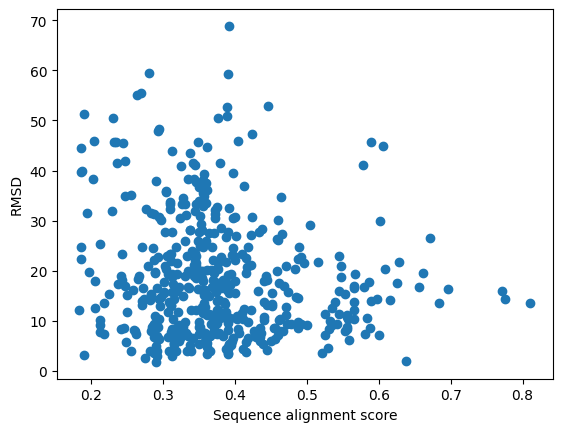

In [108]:
plt.scatter(x,y)
plt.xlabel("Sequence alignment score")
plt.ylabel("RMSD")
plt.show()

The model performs very badly on a diverse set of proteins as shown by the very low proportion of structures with rmsd < 2 and rmsd < 5. In addition, we can see that the model performance is not correlated with how high the sequences are aligned. Thus, there is very poor generalisability overall. Hence this indicates a limitation of our experiments, that is the results may not be generalisable to the broader PDBBind dataset.

## Conclusion
In this work we have thoroughly explored the effects of order and parity of irreps of spherical harmonics in protein-ligand docking, specifically in the DiffDock model. Our results show the following:
* Higher order irreps (higher $l_{max}$ and $shl_{max}$) perform better than lower order irreps. With significant improvements from $l_{max}=0$ to $l_{max}=1$, that is from an invariant model to an equivariant model. However, there is little improvement with higher order irreps. This may be due to the low symmetry nature of the protein-ligand docking problem allowing the system to be well represented by low order irreps. Thus, this justifies the author's choice of $l_{max}=1$, $shl_{max}=2$. We do see that higher order irreps provide better training efficiency, which is consistent with similar results seen in other equivariant neural networks for molecular dynamics simulations [8], [4].
* Combination of both parities, odd and even, for the output translation, rotation, and torsion scores perform the best. Intuitively it is expected that these scores should have parity and transform as either even or odd irreps under inversion. However, due to the coarse graining of the protein the transformations under inversion are not predictable. Thus, combination of both irreps seems most appropiate. Our experiments have been able to demonstrate that using only one parity reduces model performance and empirically justifies the author's choice.
* SO(3) performs worse than O(3). Thus, inversion symmetry is important for the translation, rotation, and torsion scores. This follows on from the previous experiment on determining the effect of parities.

### Limitations and future avenues
The model is not generalisable to a diverse set of proteins. This is expected due to the lack of protein diversity in the training set, but is nonetheless a limitation of our experiments, so we must note that our results may not be generalisable to the broader PDBBind dataset. Hence, future work will involve exploring these relationships on a more diverse set of proteins. In addition, our experiments have so far only only considered the coarse grained model in DiffDock. Future work will involve also testing the effects of order and parity of irreps on the all-atom model (the confidence model) in DiffDock, where the transformations under symmetry operations (particularly inversion) may be more predictable.

## Citations
[1] G. Corso, H. St ̈ark, B. Jing, R. Barzilay, and T. Jaakkola, “Diffdock: Diffusion steps, twists, and turns
for molecular docking,” arXiv preprint arXiv:2210.01776, 2022.

[2] H. St ̈ark, O. Ganea, L. Pattanaik, R. Barzilay, and T. Jaakkola, “Equibind: Geometric deep learning
for drug binding structure prediction,” in International Conference on Machine Learning, pp. 20503–
20521, PMLR, 2022.

[3] W. Lu, Q. Wu, J. Zhang, J. Rao, C. Li, and S. Zheng, “Tankbind: Trigonometry-aware neural networks
for drug-protein binding structure prediction,” bioRxiv, pp. 2022–06, 2022.

[4] S. Batzner, A. Musaelian, L. Sun, M. Geiger, J. P. Mailoa, M. Kornbluth, N. Molinari, T. E. Smidt,
and B. Kozinsky, “E (3)-equivariant graph neural networks for data-efficient and accurate interatomic
potentials,” Nature communications, vol. 13, no. 1, p. 2453, 2022.

[5] M. Geiger and T. Smidt, “e3nn: Euclidean Neural Networks,” July 2022. arXiv:2207.09453 [cs].

[6] J. Hestness, S. Narang, N. Ardalani, G. Diamos, H. Jun, H. Kianinejad, M. Patwary, M. Ali, Y. Yang, and
Y. Zhou, “Deep learning scaling is predictable, empirically,” arXiv preprint arXiv:1712.00409, 2017.

[7] J. Hestness, S. Narang, N. Ardalani, G. Diamos, H. Jun, H. Kianinejad, M. M. A. Patwary, Y. Yang, and
Y. Zhou, “Deep Learning Scaling is Predictable, Empirically,” Dec. 2017. arXiv:1712.00409 [cs, stat].

[8] C. J. Owen, S. B. Torrisi, Y. Xie, S. Batzner, J. Coulter, A. Musaelian, L. Sun, and B. Kozinsky, “Com-
plexity of many-body interactions in transition metals via machine-learned force fields from the tm23
data set,” arXiv preprint arXiv:2302.12993, 2023.

[9] A. Rives, J. Meier, T. Sercu, S. Goyal, Z. Lin, J. Liu, D. Guo, M. Ott, C. L. Zitnick, J. Ma, and
R. Fergus, “Biological structure and function emerge from scaling unsupervised learning to 250 million
protein sequences,” Proceedings of the National Academy of Sciences, vol. 118, p. e2016239118, Apr.
2021. Publisher: Proceedings of the National Academy of Sciences.